# Patch Foraging Simulation
To-Do List:
- Lower false alarm bin size by dividing rate by decrement factor (e.g. if decrease bin size by n, then divide fa rate by n)
- Plot comparison of behavioral data with simulation data
- Make RL agent for task


## Initial setup

In [1]:
# Global imports
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Simulations
import math
from random import random, randint

# Data file processing
import os
import re
import h5py # if using -v7.3 mat data
#import scipy.io as sio # if using -v7 mat data
from scipy.stats import norm # for z-score calculation

C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Fixed Model

### Create environment

In [2]:
class PatchEnvironment:
    
    def __init__(self,
                 d_interpatch, 
                 r_init, 
                 decay=0.1,
                 nc_avg=1.0,
                 target_duration=1.0,
                 max_trial_duration=4.0,
                 iti=1.5,
                 fa_timeout=4.0,
                 end_patch_type=None,
                 end_patch_val=None):
        
        # Patch settings
        self.d_interpatch = d_interpatch
        self.r_init = r_init
        self.decay = decay
        self.nc_avg = nc_avg
        self.target_duration = target_duration
        self.max_trial_duration = max_trial_duration
        self.iti = iti
        self.fa_timeout = fa_timeout
        self.end_patch_type = end_patch_type
        if isinstance(end_patch_val, list):
            self.end_patch_params = end_patch_val
            self.end_patch_val = randint(end_patch_val[0], end_patch_val[1])
        else:
            self.end_patch_params = None
            self.end_patch_val = end_patch_val
        
        # Tracking indices
        self.trial = 0
    
    @property
    def info(self):
        return {'d_interpatch': self.d_interpatch,
                'r_init': self.r_init,
                'decay': self.decay,
                'nc_avg': self.nc_avg,
                'target_duration': self.target_duration,
                'max_trial_duration': self.max_trial_duration,
                'intertrial_interval': self.iti,
                'fa_timeout': self.fa_timeout,
                'end_patch_type': self.end_patch_type,
                'end_patch_params': self.end_patch_params,
                'end_patch_val': self.end_patch_val}
    
    def reset_patch(self):
        self.trial = 0
        if self.end_patch_params is not None:
            self.end_patch_val = randint(self.end_patch_params[0], self.end_patch_params[1])
    
    def create_trial(self):
        """
        Creates trial based on patch settings. If patch is depleted, then return no targets.
        Otherwise, return delay to target sampled from exponential distribution (flat hazard rate).
        
        Returns:
        - nc_time: duration of delay to target
        - catch_trial: True if catch trial
        """
        if self.is_patch_depleted():
            return self.max_trial_duration, False
        else:
            lambda_ = 1.0 / self.nc_avg
            nc_time = -(1.0/lambda_) * math.log(1.0 - random()) # inverse transform sampling of exponential distribution
            
            if nc_time > self.max_trial_duration:
                nc_time = self.max_trial_duration
                catch_trial = True
            else:
                catch_trial = False
            
            return nc_time, catch_trial
    
    def give_reward(self):
        # Give current reward volume based on reward function and patch end function
        if self.is_patch_depleted():
            return 0.0
        else:
            return self._get_reward_volume()
    
    def increment_counter(self, n=1):
        self.trial += n
    
    def _get_reward_volume(self):
        return self.r_init * (1 - self.decay)**self.trial
    
    def is_patch_depleted(self):
        if self.end_patch_type == None:
            return False
        elif self.end_patch_type == 'reward':
            return self._get_reward_volume() < self.end_patch_val
        elif self.end_patch_type == 'trial':
            return self.trial >= self.end_patch_val
        else:
            raise ValueError('Unknown end patch type %s' % self.end_patch_type)

In [3]:
class Rodent:
    
    def __init__(self, 
                 hit_rate, 
                 fa_rate, 
                 velocity,
                 walk_bout=None,
                 still_bout=None,
                 decision_type='reward', 
                 decision_val=2.0):
        
        # Set animal parameters
        self.hit_rate = hit_rate
        self.fa_rate = fa_rate
        self.velocity = velocity
        self.walk_bout = walk_bout
        self.still_bout = still_bout
        self.decision_type = decision_type
        self.decision_val = decision_val
        
        # Sample initial parameters
        self.dv = self._check_callable(self.decision_val)
        self.hr = self._check_callable(self.hit_rate)
        self.far = self._check_callable(self.fa_rate)
        
        self.result_idx = {'hit': 0,
                           'miss': 1,
                           'false_alarm': 2,
                           'catch': 3}
    
    def _check_callable(self, f):
        if callable(f):
            return f()
        else:
            return f
    
    def leave_patch(self, last_reward, t_patch, n_patch):
        """
        Either choose to stay in patch (and harvest reward) or leave patch (and incur travel time delay).
        Args:
        - last_reward: last reward harvested in patch (or 0 if none harvested)
        - t_patch: time spent in current patch
        - n_patch: number of trials in current patch
        
        Returns:
        - boolean that is True if animal decides to leave patch
        """
        # Determine leaving decision
        if self.decision_type == 'reward':
            if n_patch == 0:
                leave = False
            else:
                leave = last_reward <= self.dv
        elif self.decision_type == 'time':
            leave = t_patch >= self.dv
        elif self.decision_type == 'trial':
            leave = n_patch >= self.dv
        else:
            raise ValueError('Decision type %s not recognized.' % self.decision_type)
        
        # Sample new parameters if leaving patch
        if leave:
            self.dv = self._check_callable(self.decision_val)
            self.hr = self._check_callable(self.hit_rate)
            self.far = self._check_callable(self.fa_rate)
        
        return leave
    
    def harvest_reward(self, nc_duration, target_duration, catch_trial=False):
        """
        Attempt to collect reward given limitations of parameters.
        Args:
        - nc_duration: delay to target start
        - target_duration: length of target tone
        - catch_trial: True if catch trial
        
        Returns:
        - result: indexed result based on dictionary above
        - t_result: time from trial start to when result occurred
        """
        # Model false alarm as n Bernoulli trials
        num_blocks = nc_duration / target_duration
        n = 5 # scaling factor for precision
        fa_in_block = (self.far/n) > np.random.rand(int(num_blocks*n)) # true if FA in time block
        false_alarm = np.sum(fa_in_block) > 0 # FA occurred in any time block
        
        # (cannot use binomial distribution since lose time information)
        #num_blocks = nc_duration / target_duration # standard bin size
        #p_no_fa = (1.0 - self.far)**(num_blocks) # p(~fa)^n
        #false_alarm = random() > p_no_fa # or random() < (1-p_no_fa)
        
        # False alarm
        if false_alarm:
            # Time to false alarm = bin_idx * t_bin
            t_fa = (np.nonzero(fa_in_block)[0][0] + 0.5) * (target_duration/n)
            return self.result_idx['false_alarm'], t_fa
        
        # Get reward if no false alarm during catch trial
        elif catch_trial:
            return self.result_idx['catch'], nc_duration

        # Otherwise, get reward based on hit rate
        elif self.hr > random():
            return self.result_idx['hit'], nc_duration + target_duration / 2
        else:
            return self.result_idx['miss'], nc_duration + target_duration
    
    def get_travel_time(self, distance):
        # Sample walk-bout durations if provided
        d_walk = 0
        t_travel = 0
        if self.walk_bout is not None:
            while d_walk < distance:
                t_walk = self._check_callable(self.walk_bout)
                v = self._check_callable(self.velocity)
                d_walk += v * t_walk
                t_still = self._check_callable(self.still_bout)
                t_travel += t_walk + t_still
            return t_travel
        
        # Otherwise, assume traveled interpatch length
        else:
            v = self._check_callable(self.velocity)
            return distance / v

In [4]:
class EmpiricalDistribution:
    
    def __init__(self, x, bins=10, outlier_thresh=None):
        if outlier_thresh is not None:
            x = remove_outliers(x, thresh=outlier_thresh)
        [counts, bin_edges] = np.histogram(x, bins=bins)
        self.n = counts
        self.bins = bin_edges
        self.p = counts / np.sum(counts)
        
    def get_sample(self, size=1):
        idx = np.random.choice(self.bins.size-1, size=size, replace=True, p=self.p)
        return self.bins[idx] + np.random.uniform(size=size)*(self.bins[idx+1]-self.bins[idx])

In [5]:
def run_simulation(num_steps, mouse, patch, verbose=False):

    n_patch = 0 # trial number
    t_patch = 0.0 # time in patch
    t_total = 0.0 # total time
    r_total = 0.0 # total reward harvested
    num_patches = 1 # number of patches explored
    r_last = math.inf # last reward in patch

    for i in range(num_steps):

        # Make stay or go decision
        leave = mouse.leave_patch(r_last, t_patch, n_patch)

        # If leave, incur travel cost and reset patch
        if leave:
            r_step = 0.0
            t_step = mouse.get_travel_time(patch.d_interpatch)
            n_patch = 0
            t_patch = 0.0
            r_last = math.inf
            num_patches += 1
            patch.reset_patch()

        # Otherwise, attempt signal detection task to harvest reward
        else:
            # Get trial from patch
            nc_time, catch_trial = patch.create_trial()
            result, t_result = mouse.harvest_reward(nc_time, patch.target_duration, catch_trial)

            # Penalize with timeout if false alarm
            if (result == 2):
                r_step = 0.0
                t_step = t_result + patch.fa_timeout + patch.iti

            # Get reward if hit or successful catch trial
            elif (result == 0) or (result == 3): 
                r_step = patch.give_reward()
                r_last = r_step
                t_step = nc_time + patch.target_duration * (1 - catch_trial) + patch.iti

            # Do not reward but do not penalize if miss
            elif (result == 1):
                r_step = 0.0
                t_step = nc_time + patch.target_duration + patch.iti

            else:
                raise ValueError('Unknown result index: %d' % result)

            # Increment patch counters
            patch.increment_counter()
            n_patch += 1
            t_patch += t_step

        # Increment global counters
        t_total += t_step
        r_total += r_step

        # Print progress
        if verbose and (i % 100 == 0):
            print("Step %d" % i)
    
    # Reset patch object
    patch.reset_patch()
    
    if verbose:
        harvest_rate = r_total / t_total
        print("Total reward: %.2f uL" % r_total)
        print("Total time: %.2f s" % t_total)
        print("Harvest rate: %.3f uL/s" % harvest_rate)
    
    return r_total, t_total, num_patches

### Sanity check
Step-by-step walkthrough to check for blatant errors.

In [ ]:
n_patch = 0 # trial number
t_patch = 0.0 # time in patch
t_total = 0.0 # total time
r_total = 0.0 # total reward harvested
num_patches = 1 # number of patches explored
r_last = math.inf # last reward in patch
verbose = True
num_steps = 10

for i in range(num_steps):

    # Make stay or go decision
    leave = mouse.leave_patch(r_last, t_patch, n_patch)

    # If leave, incur travel cost and reset patch
    if leave:
        r_step = 0.0
        t_step = mouse.get_travel_time(patch.d_interpatch)
        n_patch = 0
        t_patch = 0.0
        r_last = math.inf
        num_patches += 1
        patch.reset_patch()

    # Otherwise, attempt signal detection task to harvest reward
    else:
        # Get trial from patch
        nc_time, catch_trial = patch.create_trial()
        result, t_result = mouse.harvest_reward(nc_time, patch.target_duration, catch_trial)

        # Penalize with timeout if false alarm
        if (result == 2):
            r_step = 0.0
            t_step = t_result + patch.fa_timeout + patch.iti

        # Get reward if hit or successful catch trial
        elif (result == 0) or (result == 3): 
            r_step = patch.give_reward()
            r_last = r_step
            t_step = nc_time + patch.target_duration * (1 - catch_trial) + patch.iti

        # Do not reward but do not penalize if miss
        elif (result == 1):
            r_step = 0.0
            t_step = nc_time + patch.target_duration + patch.iti

        else:
            raise ValueError('Unknown result index: %d' % result)

        # Increment patch counters
        patch.increment_counter()
        n_patch += 1
        t_patch += t_step

    # Increment global counters
    t_total += t_step
    r_total += r_step

    # Print progress
    if verbose and (i % 100 == 0):
        print("Step %d" % i)

if verbose:
    harvest_rate = r_total / t_total
    print("Total reward: %.2f uL" % r_total)
    print("Total time: %.2f s" % t_total)
    print("Harvest rate: %.3f uL/s" % harvest_rate)

### Hit rate = 1.0, FA rate = 0.0 (control)

#### Run simulation

In [30]:
# Environment parameters
d_interpatch = 25.0
r_init = 12.0
decay = 0.1
nc_avg = 1.0
target_duration = 1.0
max_trial_duration = 4.0
iti = 1.5
fa_timeout = 4.0
end_patch_type = None
end_patch_val = None

# Animal parameters
hit_rate = 1.0
fa_rate = 0.0
velocity = 5.0
decision_type = 'reward'
decision_val = np.linspace(2.0, 12.0, num=int((12.0-2.0)/0.1)+1)

# Experiment parameters
exp_name = 'trial_1'
num_steps_per_sim= 1000
num_sims_per_value = 5

# Create environment
patch = PatchEnvironment(d_interpatch,
                         r_init, 
                         decay,
                         nc_avg=nc_avg,
                         target_duration=target_duration,
                         max_trial_duration=max_trial_duration,
                         iti=iti,
                         fa_timeout=fa_timeout,
                         end_patch_type=end_patch_type,
                         end_patch_val=end_patch_val)

# Run simulations
r_total = np.zeros([decision_val.shape[0], num_sims_per_value])
t_total = np.zeros([decision_val.shape[0], num_sims_per_value])
num_patches = np.zeros([decision_val.shape[0], num_sims_per_value])
for i, dv in enumerate(decision_val):
    # Create animal object
    mouse = Rodent(hit_rate,
                   fa_rate,
                   velocity,
                   decision_type,
                   dv)

    for j in range(num_sims_per_value):
        r_total[i, j], t_total[i, j], num_patches[i, j] = run_simulation(num_steps_per_sim, mouse, patch)

#### Plot performance curve

Max harvest rate: 2.20 uL/s
Reward threshold at max: 8.10 uL


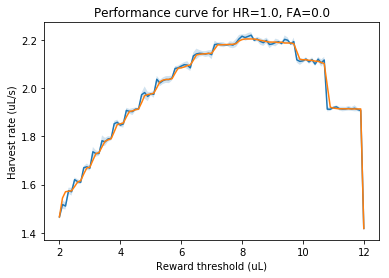

In [37]:
# Calculate harvest rate mean and std
mean = np.mean(r_total/t_total, axis=1)
std = np.std(r_total/t_total, axis=1)

# Smooth curve with 1D median filter
mean_smooth = np.zeros(mean.shape)
n = 10 # filter size
mean_smooth[0] = mean[0]
mean_smooth[-1] = mean[-1] # anchor at ends
for i in range(1, mean.shape[0]-1):
    mean_smooth[i] = np.median(mean[max(i-n//2, 0):min(i+n//2, mean.shape[0]-1)])

# Plot results
fig, ax = plt.subplots()
p_mean = ax.plot(decision_val, mean)
p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
p_mean_smooth = ax.plot(decision_val, mean_smooth)
p_xlabel = ax.set_xlabel('Reward threshold (uL)')
p_ylabel = ax.set_ylabel('Harvest rate (uL/s)')
p_title = ax.set_title('Performance curve for HR=1.0, FA=0.0')

print("Max harvest rate: %.2f uL/s" % np.max(mean_smooth))
print("Reward threshold at max: %.2f uL" % decision_val[np.argmax(mean_smooth)])

### Multiple hit rate, fa rate combinations

#### Run simulations

In [39]:
# Experiment parameters
num_steps_per_sim= 1000
num_sims_per_value = 5
exp_name = 'trial_1'
exp_desc = 'data shape = [hit_rate, fa_rate, reward_thresh, num_sims]'

# Environment parameters
d_interpatch = 25.0
r_init = 12.0
decay = 0.1
nc_avg = 1.0
target_duration = 1.0
max_trial_duration = 4.0
iti = 1.5
fa_timeout = 4.0
end_patch_type = None
end_patch_val = None

# Animal parameters
hit_rate = np.arange(11) / 10
fa_rate = np.arange(11) / 10
velocity = 5.0
decision_type = 'reward'
decision_val = np.linspace(2.0, 12.0, num=int((12.0-2.0)/0.1)+1)

# Create environment
patch = PatchEnvironment(d_interpatch,
                         r_init, 
                         decay,
                         nc_avg=nc_avg,
                         target_duration=target_duration,
                         max_trial_duration=max_trial_duration,
                         iti=iti,
                         fa_timeout=fa_timeout,
                         end_patch_type=end_patch_type,
                         end_patch_val=end_patch_val)


# Run simulations
r_total = np.zeros([hit_rate.shape[0], fa_rate.shape[0], decision_val.shape[0], num_sims_per_value])
t_total = np.zeros([hit_rate.shape[0], fa_rate.shape[0], decision_val.shape[0], num_sims_per_value])
num_patches = np.zeros([hit_rate.shape[0], fa_rate.shape[0], decision_val.shape[0], num_sims_per_value])
for i, hr in enumerate(hit_rate):
    for j, far in enumerate(fa_rate):
        print("Simulating hit rate %.2f, fa rate %.2f" % (hr, far))
        for k, dv in enumerate(decision_val):
            # Create animal object
            mouse = Rodent(hr,
                           far,
                           velocity,
                           decision_type,
                           dv)

            for l in range(num_sims_per_value):
                r_total[i, j, k, l], t_total[i, j, k, l], num_patches[i, j, k, l] = \
                    run_simulation(num_steps_per_sim, mouse, patch)

Simulating hit rate 0.00, fa rate 0.00
Simulating hit rate 0.00, fa rate 0.10
Simulating hit rate 0.00, fa rate 0.20
Simulating hit rate 0.00, fa rate 0.30
Simulating hit rate 0.00, fa rate 0.40
Simulating hit rate 0.00, fa rate 0.50
Simulating hit rate 0.00, fa rate 0.60
Simulating hit rate 0.00, fa rate 0.70
Simulating hit rate 0.00, fa rate 0.80
Simulating hit rate 0.00, fa rate 0.90
Simulating hit rate 0.00, fa rate 1.00
Simulating hit rate 0.10, fa rate 0.00
Simulating hit rate 0.10, fa rate 0.10
Simulating hit rate 0.10, fa rate 0.20
Simulating hit rate 0.10, fa rate 0.30
Simulating hit rate 0.10, fa rate 0.40
Simulating hit rate 0.10, fa rate 0.50
Simulating hit rate 0.10, fa rate 0.60
Simulating hit rate 0.10, fa rate 0.70
Simulating hit rate 0.10, fa rate 0.80
Simulating hit rate 0.10, fa rate 0.90
Simulating hit rate 0.10, fa rate 1.00
Simulating hit rate 0.20, fa rate 0.00
Simulating hit rate 0.20, fa rate 0.10
Simulating hit rate 0.20, fa rate 0.20
Simulating hit rate 0.20,

#### Save results

In [108]:
results_dir = 'G:\\My Drive\\Projects\\foraging\\data\\simulation_data\\%s\\' % exp_name

# Save data
np.save(results_dir + 'r_total', r_total)
np.save(results_dir + 't_total', t_total)
np.save(results_dir + 'num_patches', num_patches)
np.save(results_dir + 'hit_rate', hit_rate)
np.save(results_dir + 'fa_rate', fa_rate)

# Write settings file
f = open(results_dir + 'settings.txt', 'w')
f.write('Experiment params:\n')
f.write('Description: ' + exp_desc + '\n')
f.write('Steps per simulation = %d\n' % num_steps_per_sim)
f.write('Simulations per decision value = %d\n' % num_sims_per_value)
f.write('\nEnvironment params:\n')
f.write('d_interpatch = %.2f\n' % d_interpatch)
f.write('r_init = %.2f\n' % r_init)
f.write('decay = %.2f\n' % decay)
f.write('nc_avg = %.2f\n' % nc_avg)
f.write('target_duration = %.2f\n' % target_duration)
f.write('max_trial_duration = %.2f\n' % max_trial_duration)
f.write('iti = %.2f\n' % iti)
f.write('fa_timeout = %.2f\n' % fa_timeout)
f.write('end_patch_type = %s\n' % end_patch_type)
f.write('end_patch_val = %s\n' % str(end_patch_val))
f.write('\nAnimal params:\n')
if isinstance(hit_rate, np.ndarray):
    f.write('hit_rate = %s\n' %
            ('[' + ', '.join([str(hr) for hr in hit_rate]) + ']'))
else:
    f.write('hit_rate = %.2f\n' % hit_rate)
if isinstance(fa_rate, np.ndarray):
    f.write('fa_rate = %s\n' %
            ('[' + ', '.join([str(far) for far in fa_rate]) + ']'))
else:
    f.write('fa_rate = %.2f\n' % fa_rate)
f.write('velocity = %.2f\n' % velocity)
f.write('decision_type = %s\n' % decision_type)
if isinstance(decision_val, np.ndarray):
    f.write('decision_val = %s\n' % 
            ('[' + ', '.join([str(dv) for dv in decision_val]) + ']'))
else:
    f.write('decision_val = %.2f\n' % decision_val)
f.close()

#### Plot performance curves

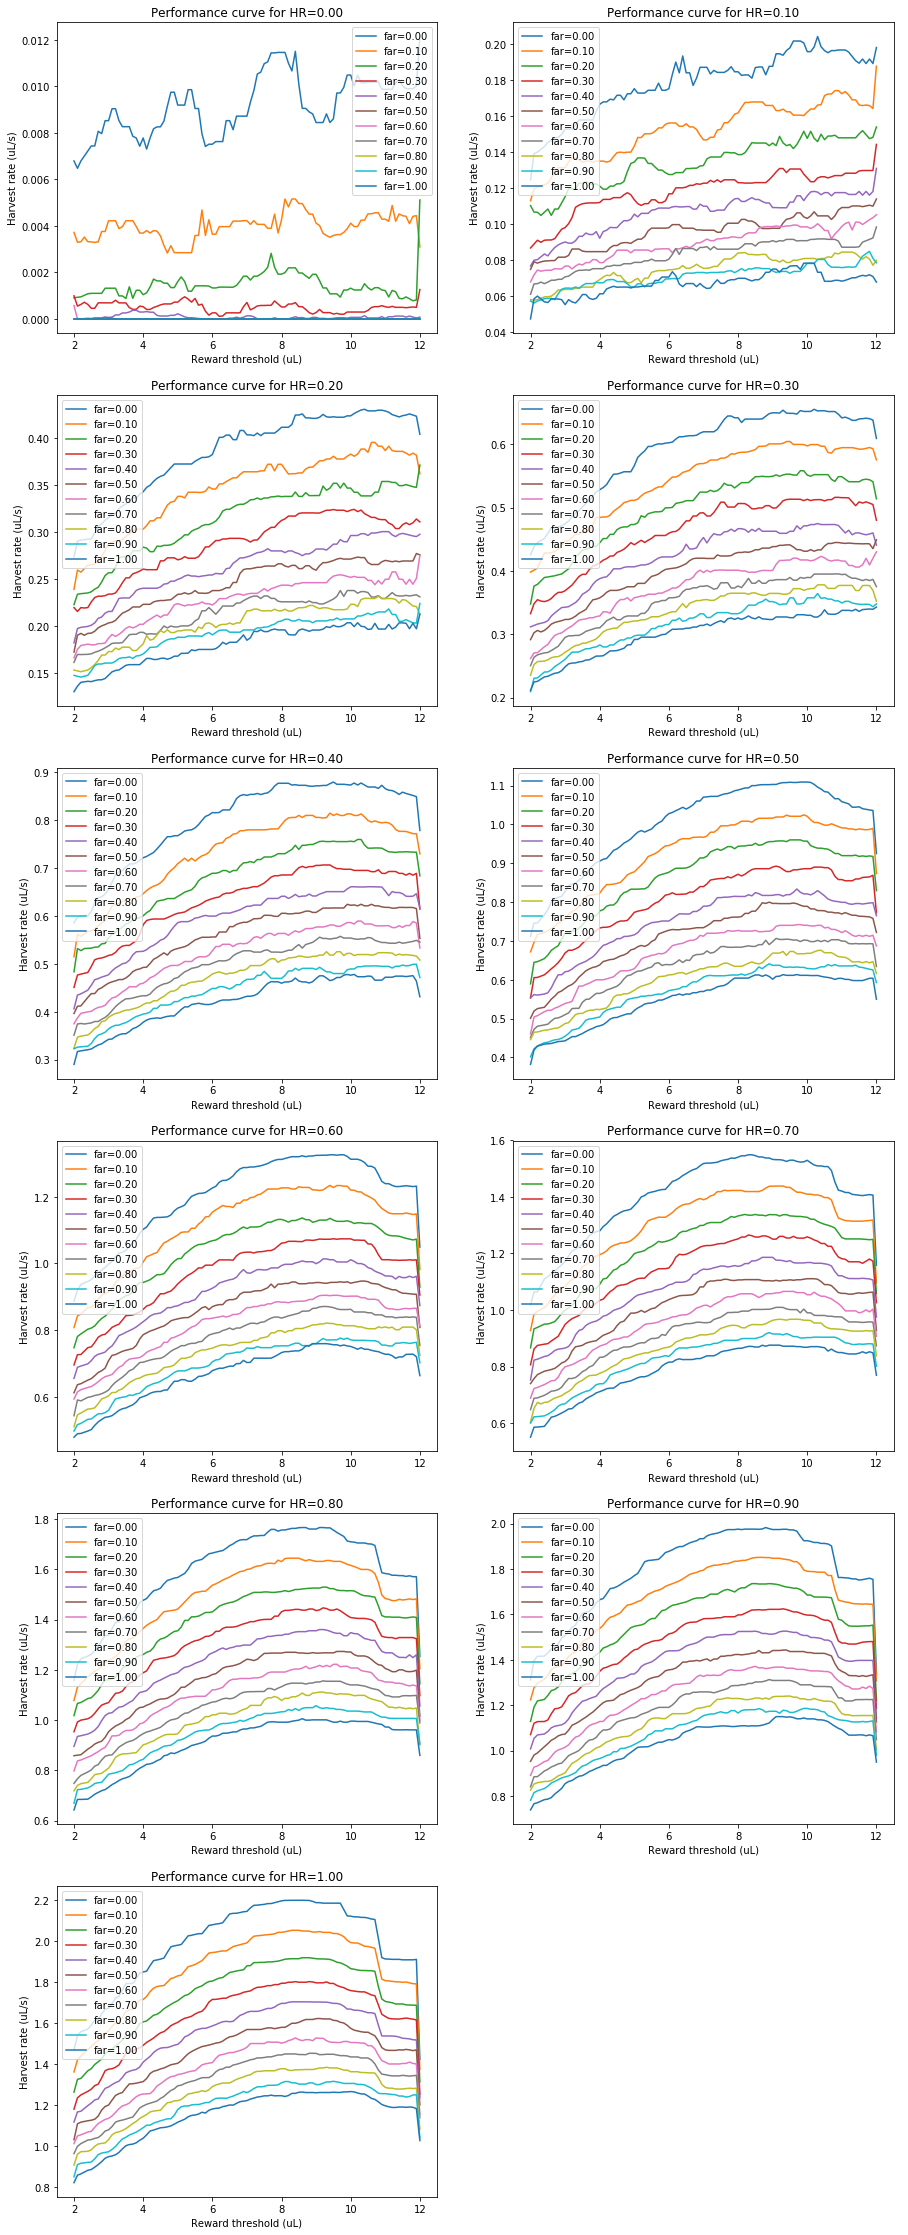

In [112]:
# Plot harvest rate vs. leaving threshold
harvest_rate = np.zeros([hit_rate.shape[0], fa_rate.shape[0]])
r_thresh = np.zeros([hit_rate.shape[0], fa_rate.shape[0]])
fig, ax = plt.subplots(fa_rate.shape[0]//2+1, 2, figsize=(15, 40))
for i, hr in enumerate(hit_rate):
    for j, far in enumerate(fa_rate):
        # Calculate harvest rate mean and std
        mean = np.mean(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)
        std = np.std(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)

        # Smooth curve with 1D median filter
        mean_smooth = np.zeros(mean.shape)
        n = 10 # filter size
        mean_smooth[0] = mean[0]
        mean_smooth[-1] = mean[-1] # anchor at ends
        for k in range(1, mean.shape[0]-1):
            mean_smooth[k] = np.median(mean[max(k-n//2, 0):min(k+n//2, mean.shape[0]-1)])
        harvest_rate[i, j] = np.max(mean_smooth)
        r_thresh[i, j] = decision_val[np.argmax(mean_smooth)]
        
        # Plot results
        #p_mean = ax.plot(decision_val, mean)
        #p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
        p_mean_smooth = ax[i//2, i%2].plot(decision_val, mean_smooth, label='far=%.2f' % (far))
        
    p_xlabel = ax[i//2, i%2].set_xlabel('Reward threshold (uL)')
    p_ylabel = ax[i//2, i%2].set_ylabel('Harvest rate (uL/s)')
    p_title = ax[i//2, i%2].set_title('Performance curve for HR=%.2f' % hr)
    l = ax[i//2, i%2].legend()

_ = ax[-1, -1].axis('off')

# Save plot
plt.savefig(results_dir + 'performance_curves.png')

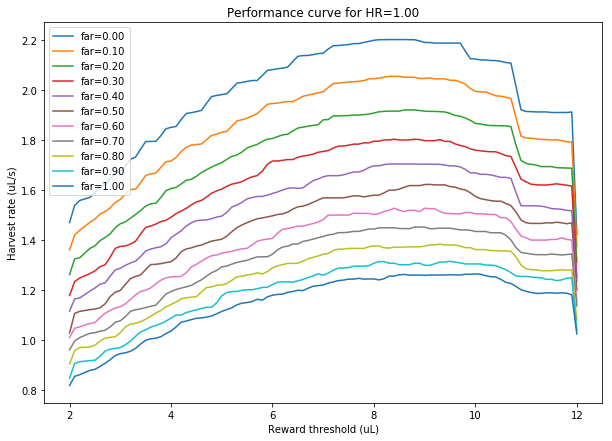

In [117]:
i = hit_rate.shape[0]-1
hr = hit_rate[i]
fig, ax = plt.subplots(figsize=(10, 7))
for j, far in enumerate(fa_rate):
    # Calculate harvest rate mean and std
    mean = np.mean(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)
    std = np.std(r_total[i, j, :, :]/t_total[i, j, :, :], axis=1)

    # Smooth curve with 1D median filter
    mean_smooth = np.zeros(mean.shape)
    n = 10 # filter size
    mean_smooth[0] = mean[0]
    mean_smooth[-1] = mean[-1] # anchor at ends
    for k in range(1, mean.shape[0]-1):
        mean_smooth[k] = np.median(mean[max(k-n//2, 0):min(k+n//2, mean.shape[0]-1)])
    harvest_rate[i, j] = np.max(mean_smooth)
    r_thresh[i, j] = decision_val[np.argmax(mean_smooth)]

    # Plot results
    #p_mean = ax.plot(decision_val, mean)
    #p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
    p_mean_smooth = ax.plot(decision_val, mean_smooth, label='far=%.2f' % (far))
        
p_xlabel = ax.set_xlabel('Reward threshold (uL)')
p_ylabel = ax.set_ylabel('Harvest rate (uL/s)')
p_title = ax.set_title('Performance curve for HR=%.2f' % hr)
l = ax.legend()

#### Plot heatmaps

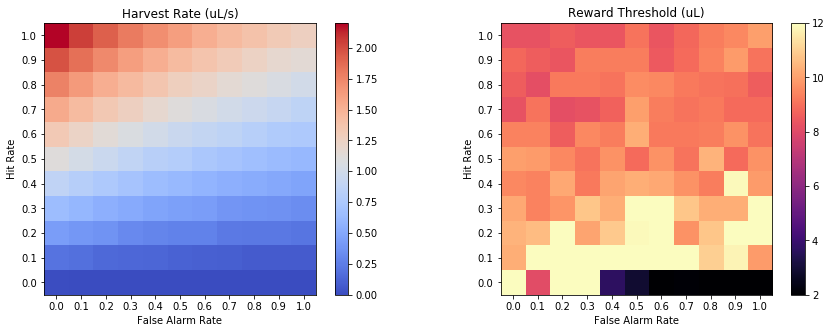

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap of harvest rate
heatmap = ax[0].imshow(harvest_rate[::-1, :], cmap='coolwarm')
cbar = fig.colorbar(heatmap, ax=ax[0])
xticks = ax[0].set_xticks(np.arange(11))
xtick_labels = ax[0].set_xticklabels(fa_rate)
yticks = ax[0].set_yticks(np.arange(11))
ytick_labels = ax[0].set_yticklabels(hit_rate[::-1])
xlabel = ax[0].set_xlabel('False Alarm Rate')
ylabel = ax[0].set_ylabel('Hit Rate')
title = ax[0].set_title('Harvest Rate (uL/s)')

# Plot heatmap of reward threshold
heatmap = ax[1].imshow(r_thresh[::-1, :], cmap='magma')
cbar = fig.colorbar(heatmap, ax=ax[1])
xticks = ax[1].set_xticks(np.arange(11))
xtick_labels = ax[1].set_xticklabels(fa_rate)
yticks = ax[1].set_yticks(np.arange(11))
ytick_labels = ax[1].set_yticklabels(hit_rate[::-1])
xlabel = ax[1].set_xlabel('False Alarm Rate')
ylabel = ax[1].set_ylabel('Hit Rate')
title = ax[1].set_title('Reward Threshold (uL)')

# Save plots
plt.savefig(results_dir + 'heatmaps.png')

## Compare simulation with behavioral data

### Define simulation of mouse session
A couple of things to note when grabbing session data from matlab files:
- **Fractions** (e.g. decay rate, hit rate, false alarm rate) are likely saved as *percentages*, so be sure to divide by 100.
- **Booleans** (e.g. end_patch_type), like other data types, are first converted to a char array from ASCII indices. However, python will incorrectly cast all char arrays as True, so string match must be used to correctly convert the char array to a boolean.

In [6]:
def simulate_sessions(sessions,
                      num_steps_per_sim,
                      num_sims_per_value,
                      velocity=None,
                      decision_type='reward',
                      decision_val=5.0,
                      sdt_metrics='session',
                      sdt_bins=20,
                      hit_rate_dist=None,
                      fa_rate_dist=None,
                      walk_metrics='fixed',
                      walk_bout_dist=None,
                      still_bout_dist=None,
                      still_bout_as_dv=False, # ugh hacky
                      session_names=None,
                      verbose=True):
    """
    """
    # Get number of decision values to iterate
    try:
        s = decision_val.shape[0]
    except AttributeError:
        s = 1
        decision_val = [decision_val]
    
    # Data placeholders
    r_total = np.zeros([len(sessions), s, num_sims_per_value])
    t_total = np.zeros([len(sessions), s, num_sims_per_value])
    num_patches = np.zeros([len(sessions), s, num_sims_per_value])
    env_data = []
    if session_names is not None:
        names = session_names
    else:
        names = sessions
    
    # Run over all sessions
    for i, sess in enumerate(sessions):
        with h5py.File(sess) as f:
            # Environment parameters
            struct = f['Settings']['Property'] # matlab data structure
            d_interpatch = struct['SoundConfigurationRunConfigInterPatchDistcm'] # char array
            d_interpatch = float([u''.join(chr(c) for c in d_interpatch)][0]) # float
            r_init = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigRewarduL'])][0])
            decay = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigDecay'])][0]) / 100.0
            nc_avg = float([u''.join(chr(c) for c in struct['SoundConfigurationTargetSoundConfigAvgStartsec'])][0])
            target_duration = float([u''.join(chr(c) for c in struct['SoundConfigurationTargetSoundConfigTargetDurationsec'])][0])
            max_trial_duration = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTrialDurationMaxsec'])][0])
            iti = 1.5 # hard-coded
            fa_timeout = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigFalseAlarmTimeoutsec'])][0])
            try:
                end_patch_trial = \
                    'true' == [u''.join(chr(c) for c in struct['SoundConfigurationRunConfigEndtargettrial'])][0].lower()
                end_patch_reward = \
                    'true' == [u''.join(chr(c) for c in struct['SoundConfigurationRunConfigEndpatchreward'])][0].lower()
                if end_patch_trial:
                    end_patch_type = 'trial'
                    n_low = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTrialLow'])][0])
                    n_high = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTrialHigh'])][0])
                    end_patch_val = [n_low, n_high]
                elif end_patch_reward:
                    end_patch_type = 'reward'
                    end_patch_val = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigThresholduL'])][0])
                else:
                    end_patch_type = None
                    end_patch_val = None
            except KeyError as e:
                end_patch_type = None
                end_patch_val = None
            
            # Animal parameters:
            # Perceptual metrics
            if sdt_metrics == 'distribution':
                if (hit_rate_dist[i].size > 0) and (fa_rate_dist[i].size > 0):
                    d_hit_rate = EmpiricalDistribution(hit_rate_sig[i], bins=sdt_bins)
                    d_fa_rate = EmpiricalDistribution(fa_rate_sig[i], bins=sdt_bins)
                    hit_rate = lambda: d_hit_rate.get_sample(size=1)[0]
                    fa_rate = lambda: d_fa_rate.get_sample(size=1)[0]
                else:
                    hit_rate = f['UntitledS_HitRate']['Data'][0, 0] / 100.0
                    fa_rate = f['UntitledS_FARate']['Data'][0, 0] / 100.0
            elif sdt_metrics == 'session':
                hit_rate = f['UntitledS_HitRate']['Data'][0, 0] / 100.0
                fa_rate = f['UntitledS_FARate']['Data'][0, 0] / 100.0
            else:
                raise ValueError('Unknown value for sdt metrics: %s' % sdt_metrics)

            # Movement patterns
            if velocity is None:
                    v = f['UntitledWheelSpeed']['Data'][0, :]
                    v = np.median(v[v > 0.02])*100
            else:
                v = velocity
                
            if walk_metrics == 'fixed':
                walk_bout = None
                still_bout = None
            elif walk_metrics == 'session':
                if (walk_bout_dist[i].size > 0) and (still_bout_dist[i].size > 0):    
                    d_run = EmpiricalDistribution(walk_bout_dist[i], outlier_thresh=2.5)
                    d_still = EmpiricalDistribution(still_bout_dist[i], outlier_thresh=2.5)
                    walk_bout = lambda: d_run.get_sample(size=1)[0]
                    still_bout = lambda: d_still.get_sample(size=1)[0]
                else:
                    walk_bout = 0.0
                    still_bout = math.inf
            elif walk_metrics == 'global':
                d_run = EmpiricalDistribution(walk_bout_dist, outlier_thresh=2.5)
                d_still = EmpiricalDistribution(still_bout_dist, outlier_thresh=2.5)
                walk_bout = lambda: d_run.get_sample(size=1)[0]
                still_bout = lambda: d_still.get_sample(size=1)[0]
            else:
                raise ValueError('Unknown value for walk metrics: %s' % walk_metrics)
            
            if still_bout_as_dv:
                decision_val = [still_bout]

        # Create environment
        patch = PatchEnvironment(d_interpatch,
                                 r_init, 
                                 decay,
                                 nc_avg=nc_avg,
                                 target_duration=target_duration,
                                 max_trial_duration=max_trial_duration,
                                 iti=iti,
                                 fa_timeout=fa_timeout,
                                 end_patch_type=end_patch_type,
                                 end_patch_val=end_patch_val)
        env_data.append(patch.info)
        
        if verbose:
            print("Simulating rodent session %d..." % names[i])
        
        # Run simulation of environment for each decision value
        for j, dv in enumerate(decision_val):
            # Create animal object
            mouse = Rodent(hit_rate=hit_rate,
                           fa_rate=fa_rate,
                           velocity=v,
                           walk_bout=walk_bout,
                           still_bout=still_bout,
                           decision_type=decision_type,
                           decision_val=dv)
            
            # Run multiple simulations per decision value
            for k in range(num_sims_per_value):
                r_total[i, j, k], t_total[i, j, k], num_patches[i, j, k] = \
                    run_simulation(num_steps_per_sim, mouse, patch)
    
    if verbose:
        print('Done.')
    
    sim_data = {'r_total': r_total,
                't_total': t_total,
                'num_patches': num_patches}
    
    data = {'sim_data': sim_data,
            'env_data': env_data}
    
    return data

### Extract observed performance across sessions

#### Experiment settings

In [301]:
# Experiment parameters
mouse_id = 'j5z4'
exp_name = 'j5z4_11-05-18'
exp_desc = 'data shape = [session, reward_thresh, num_sims]\n' \
           + 'excluded first 20 sessions due to different variable configs'
results_dir = 'G:\\My Drive\\Projects\\foraging\\data\\simulation_data\\%s\\' % exp_name
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

#### Create list from data subdirectories

In [302]:
# Recursive algorithm for finding files
def find_files(path, files):
    # If path is file, then append to list
    if os.path.isfile(path):
        files.append(path)
        return
    
    # Otherwise, iterate through all children (files/subdirectories)
    for f in os.listdir(path):
        _ = find_files(os.path.join(path, f), files)    
        
    return files

In [303]:
# Settings
root = 'Z:\\James\\data\\' # root directory of all data files
exclude_str = 'Sound'

# Filter files by matlab extension, mouse ID
files = find_files(root, [])
filelist = []
ext = '.mat'
for file in files:
    if (file.endswith(ext)
        and mouse_id in file
        and exclude_str not in file):
        filelist.append(file)

# Find training days of all files
training_days = np.zeros(len(filelist), dtype=np.int16)
for i, f in enumerate(filelist):
    match = re.search('_d[0-9]+_', f)
    if match is not None:
        training_days[i] = int(match.group()[2:-1])
    else:
        training_days[i] = -1

# Sort filenames and save associated training days
keep_idx = (training_days >= 0)
training_days = training_days[keep_idx]
filelist = [f for i, f in enumerate(filelist) if keep_idx[i]]
sort_idx = np.argsort(training_days)
filelist = [filelist[i] for i in sort_idx]
training_days = np.sort(training_days)

# Check filelist
print('Files to analyze:')
print('Day  Filename')
for day, f in zip(training_days, filelist):
    print('%2d: ' % day, f)

Files to analyze:
Day  Filename
 1:  Z:\James\data\ChamberB\8-6-18\j5z4_d1_2018_08_06_15_29_12.mat
 2:  Z:\James\data\ChamberC\8-7-18\j5z4_d2_2018_08_07_14_26_56.mat
 3:  Z:\James\data\ChamberC\8-8-2018\j5z4_d3_2018_08_08_14_10_17.mat
 4:  Z:\James\data\ChamberC\8-9-2018\j5z4_d4_2018_08_09_14_18_55.mat
 5:  Z:\James\data\ChamberC\8-10-18\j5z4_d5_2018_08_10_13_59_58.mat
 6:  Z:\James\data\ChamberC\8-13-18\j5z4_d6_2018_08_13_15_01_11.mat
 7:  Z:\James\data\ChamberB\8-14-18\j5z4_d7_2018_08_14_14_18_09.mat
 8:  Z:\James\data\ChamberA\8-15-18\j5z4_d8_2018_08_15_13_55_19.mat
 9:  Z:\James\data\ChamberA\8-16-18\j5z4_d9_2018_08_16_15_36_27.mat
10:  Z:\James\data\ChamberA\8-17-18\j5z4_d10_2018_08_17_13_41_57.mat
11:  Z:\James\data\ChamberA\8-20-18\j5z4_d11_2018_08_20_14_09_06.mat
11:  Z:\James\data\ChamberA\8-21-18\j5z4_d11_2018_08_21_13_05_06.mat
13:  Z:\James\data\ChamberA\8-22-18\j5z4_d13_2018_08_22_13_58_48.mat
14:  Z:\James\data\ChamberA\8-23-18\j5z4_d14_2018_08_23_14_04_10.mat
15:  Z:\Jam

#### Create list from text file

In [274]:
# Settings
matlist = 'Z:\James\data\matlist.txt'
mouse_id = 'j5z3'
exclude_str = 'Sound'

# Filter files by mouse ID
f = open(matlist, 'r')
filelist = []
for i, line in enumerate(f):
    #print('%d:' % i, line.rstrip())
    if (mouse_id in line) and (exclude_str not in line):
        filelist.append(line.rstrip())

# Sort filenames and save associated training days
training_days = np.zeros(len(filelist), dtype=np.int16)
for i, f in enumerate(filelist):
    match = re.search('_d[0-9]+_', f)
    training_days[i] = int(match.group()[2:-1])
sort_idx = np.argsort(training_days)
filelist = [filelist[i] for i in sort_idx]
training_days = np.sort(training_days)

# Check filelist
print('Files to analyze:')
print('Day  Filename')
for day, f in zip(training_days, filelist):
    print('%2d: ' % day, f)

Files to analyze:
Day  Filename
 1:  Z:\James\data\ChamberB\8-6-18\j5z3_d1_2018_08_06_15_27_32.mat
 2:  Z:\James\data\ChamberC\8-7-18\j5z3_d2_2018_08_07_14_25_16.mat
 3:  Z:\James\data\ChamberC\8-8-2018\j5z3_d3_2018_08_08_14_10_24.mat
 4:  Z:\James\data\ChamberC\8-9-2018\j5z3_d4_2018_08_09_14_19_36.mat
 5:  Z:\James\data\ChamberC\8-10-18\j5z3_d5_2018_08_10_14_01_01.mat
 6:  Z:\James\data\ChamberC\8-13-18\j5z3_d6_2018_08_13_15_01_29.mat
 7:  Z:\James\data\ChamberB\8-14-18\j5z3_d7_2018_08_14_14_17_04.mat
 8:  Z:\James\data\ChamberA\8-15-18\j5z3_d8_2018_08_15_13_55_00.mat
 9:  Z:\James\data\ChamberA\8-16-18\j5z3_d9_2018_08_16_15_37_41.mat
10:  Z:\James\data\ChamberA\8-17-18\j5z3_d10_2018_08_17_13_41_42.mat
11:  Z:\James\data\ChamberA\8-20-18\j5z3_d11_2018_08_20_14_11_06.mat
12:  Z:\James\data\ChamberA\8-21-18\j5z3_d12_2018_08_21_14_47_14.mat
13:  Z:\James\data\ChamberA\8-22-18\j5z3_d13_2018_08_22_13_59_26.mat
14:  Z:\James\data\ChamberA\8-23-18\j5z3_d14_2018_08_23_14_03_22.mat
15:  Z:\Jam

#### Extract data from filelist

In [64]:
filelist = filelist[5:]
training_days = training_days[5:]

In [304]:
hit_rate_obs = np.zeros(len(filelist))
fa_rate_obs = np.zeros(len(filelist))
d_prime_obs = np.zeros(len(filelist))
c_obs = np.zeros(len(filelist))
r_total_obs = np.zeros(len(filelist))
t_total_obs = np.zeros(len(filelist))

for i in range(len(filelist)):
    with h5py.File(filelist[i]) as f:
        # Grab session-averaged metrics
        hit_rate_obs[i] = f['UntitledS_HitRate']['Data'][0, 0] / 100.0
        fa_rate_obs[i] = f['UntitledS_FARate']['Data'][0, 0] / 100.0
        d_prime_obs[i] = f['UntitledS_dPrime']['Data'][0, 0]
        c_obs[i] = f['UntitledS_c']['Data'][0, 0]
        
        # Calculate total reward over session
        r_trial = f['UntitledRewarduL']['Data'][0, :]
        result_trial = f['UntitledTrialResult']['Data'][0, :]
        r_total_obs[i] = np.sum( ((result_trial == 0) + (result_trial == 3)) * r_trial )
        
        # Extract total length of session        
        t_total_obs[i] = f['UntitledWheelTime']['Data'][0, -1] # last timestamp
        
harvest_rate_obs = r_total_obs / t_total_obs

In [305]:
# Inspect outliers
hro_med = np.median(harvest_rate_obs)
hro_std = np.std(harvest_rate_obs)
print('Harvest rate median: %.2f' % hro_med)
print('Harvest rate std: %.2f' % hro_std)
print()

print('Significant outliers (std)')
for i in range(len(filelist)):
    if (harvest_rate_obs[i] - hro_med) > 2*hro_std:
        print('Session %d (index %d)):' % (training_days[i], i))
        print('Harvest rate %.2f' % harvest_rate_obs[i])
        print('File %s' % filelist[i])
        print()
        
print('Significant outliers (value):')
thresh = 2.5 # anything above this is suspicious
for i in range(len(filelist)):
    if harvest_rate_obs[i] > thresh:
        print('Session %d (index %d)):' % (training_days[i], i))
        print('Harvest rate %.2f' % harvest_rate_obs[i])
        print('File %s' % filelist[i])
        print()

Harvest rate median: 0.08
Harvest rate std: 24.40

Significant outliers (std)
Session 1 (index 0)):
Harvest rate 142.49
File Z:\James\data\ChamberB\8-6-18\j5z4_d1_2018_08_06_15_29_12.mat

Session 7 (index 6)):
Harvest rate 68.18
File Z:\James\data\ChamberB\8-14-18\j5z4_d7_2018_08_14_14_18_09.mat

Significant outliers (value):
Session 1 (index 0)):
Harvest rate 142.49
File Z:\James\data\ChamberB\8-6-18\j5z4_d1_2018_08_06_15_29_12.mat

Session 7 (index 6)):
Harvest rate 68.18
File Z:\James\data\ChamberB\8-14-18\j5z4_d7_2018_08_14_14_18_09.mat



In [306]:
# Remove outliers as warranted
exclude_idx = np.arange(20)
keep_idx = np.isin(np.arange(len(filelist)), exclude_idx, invert=True)

print('Excluding session(s)', training_days[exclude_idx], 'from analysis.')

filelist = [f for i, f in enumerate(filelist) if i not in exclude_idx]
training_days = training_days[keep_idx]
hit_rate_obs = hit_rate_obs[keep_idx]
fa_rate_obs = fa_rate_obs[keep_idx]
d_prime_obs = d_prime_obs[keep_idx]
c_obs = c_obs[keep_idx]
r_total_obs = r_total_obs[keep_idx]
t_total_obs = t_total_obs[keep_idx]
harvest_rate_obs = r_total_obs / t_total_obs

# Repeat above as necessary

Excluding session(s) [ 1  2  3  4  5  6  7  8  9 10 11 11 13 14 15 16 17 18 19 20] from analysis.


#### Save basic behavioral data

In [307]:
# Create subfolder
d = results_dir + 'observed\\'
if not os.path.isdir(d):
    os.mkdir(d)

# Save filelist
f = open(d + 'filelist.txt', 'w')
for filename in filelist:
    f.write(filename + '\n')
f.close()
np.save(d + 'training_days', training_days)

# Save behavioral data
behavior_data = {'hit_rate': hit_rate_obs,
                 'fa_rate': fa_rate_obs,
                 'd_prime': d_prime_obs,
                 'c': c_obs,
                 'r_total': r_total_obs,
                 't_total': t_total_obs,
                 'harvest_rate': harvest_rate_obs}
np.save(d + 'behavior_data', behavior_data)

### Initial comparison
These do not take into account finer details, such as variability in hit rates, fa rates, and movement patterns within sessions, that later simulations incorporate below. 

#### Run simulations

In [308]:
# Simulation parameters
num_steps_per_sim= 1000
num_sims_per_value = 20

# Animal parameters
velocity = None # take median running velocity of each session
decision_type = 'reward'
decision_val = np.arange(2*2, 12*2+1) / 2
sdt_metrics = 'session'
#sdt_bins = np.arange(21)/20

# Run simulations
data = simulate_sessions(filelist,
                         num_steps_per_sim,
                         num_sims_per_value,
                         velocity=velocity,
                         decision_type=decision_type,
                         decision_val=decision_val,
                         sdt_metrics=sdt_metrics,
                         session_names=training_days,
                         verbose=True)
sim_data = data['sim_data']
env_data = data['env_data']

Simulating rodent session 21...
Simulating rodent session 22...
Simulating rodent session 23...
Simulating rodent session 24...
Simulating rodent session 25...
Simulating rodent session 26...
Simulating rodent session 27...
Simulating rodent session 28...
Simulating rodent session 30...
Simulating rodent session 32...
Simulating rodent session 33...
Simulating rodent session 35...
Simulating rodent session 36...
Simulating rodent session 37...
Simulating rodent session 38...
Simulating rodent session 39...
Simulating rodent session 40...
Simulating rodent session 41...
Simulating rodent session 42...
Simulating rodent session 43...
Done.


#### Calculate simulated performance across sessions

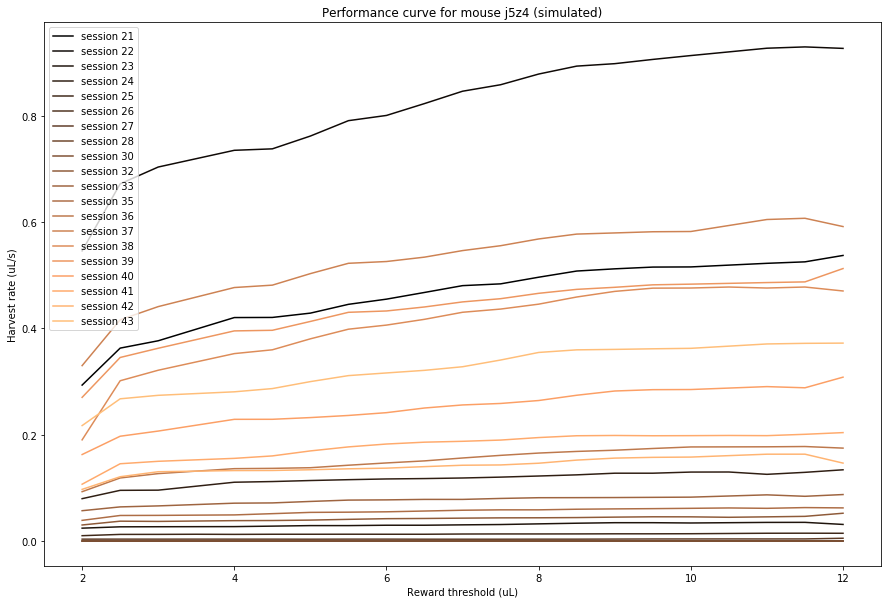

In [309]:
# Placeholders
harvest_rate_sim = np.zeros(len(filelist))
r_thresh_sim = np.zeros(len(filelist))

# Plot setup
fig, ax = plt.subplots(figsize=(15, 10))
cmap = plt.get_cmap('copper')

for i in range(len(filelist)):
    # Calculate harvest rate mean and std
    mean = np.mean(sim_data['r_total'][i, :, :]/sim_data['t_total'][i, :, :], axis=1)
    std = np.std(sim_data['r_total'][i, :, :]/sim_data['t_total'][i, :, :], axis=1)

    # Smooth curve with 1D median filter
    mean_smooth = np.zeros(mean.shape)
    n = 10 # filter size
    mean_smooth[0] = mean[0] # anchor at ends
    mean_smooth[-1] = mean[-1] # anchor at ends
    for j in range(1, mean.shape[0]-1):
        mean_smooth[j] = np.median(mean[max(j-n//2, 0):min(j+n//2, mean.shape[0]-1)])
    harvest_rate_sim[i] = np.max(mean_smooth)
    r_thresh_sim[i] = decision_val[np.argmax(mean_smooth)]

    # Plot results
    #p_mean = ax.plot(decision_val, mean)
    #p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
    p_mean_smooth = ax.plot(decision_val, 
                            mean_smooth, 
                            label='session %d' % (training_days[i]),
                            color=cmap(i/len(filelist)))
        
p_xlabel = ax.set_xlabel('Reward threshold (uL)')
p_ylabel = ax.set_ylabel('Harvest rate (uL/s)')
p_title = ax.set_title('Performance curve for mouse %s (simulated)' % mouse_id)
l = ax.legend()

# Save plot
plt.savefig(results_dir + 'sim_performance_curves.png')

#### Save simulation data

In [310]:
# Create subfolder
d = results_dir + 'basic\\'
if not os.path.isdir(d):
    os.mkdir(d)

# Save filelist
f = open(d + 'filelist.txt', 'w')
for filename in filelist:
    f.write(filename + '\n')
f.close()
    
# Save data
np.save(d + 'decision_val', decision_val)
np.save(d + 'sim_data', sim_data)
np.save(d + 'env_data', env_data)
np.save(d + 'harvest_rate', harvest_rate_sim)
np.save(d + 'r_thresh', r_thresh_sim)

# Write settings file
f = open(d + 'settings.txt', 'w')
f.write('Experiment params:\n')
f.write('Description: ' + exp_desc + '\n')
f.write('Steps per simulation = %d\n' % num_steps_per_sim)
f.write('Simulations per decision value = %d\n' % num_sims_per_value)
f.write('\nAnimal params:\n')
f.write('velocity = %s' % velocity)
f.write('decision_type = %s\n' % decision_type)
if isinstance(decision_val, np.ndarray):
    f.write('decision_val = %s\n' % 
            ('[' + ', '.join([str(dv) for dv in decision_val]) + ']'))
else:
    f.write('decision_val = %.2f\n' % decision_val)
f.write('sdt_metrics = %s' % sdt_metrics)
f.close()

#### Compare overall simulated vs. observed performance

In [311]:
f = open(d + 'filelist.txt', 'r')
filelist = [line.rstrip() for line in f]
f.close()
sim_data = np.load(d + 'sim_data.npy')
env_data = np.load(d + 'env_data.npy')
decision_val = np.load(d + 'decision_val.npy')
harvest_rate_sim = np.load(d + 'harvest_rate.npy')
r_thresh_sim = np.load(d + 'r_thresh.npy')

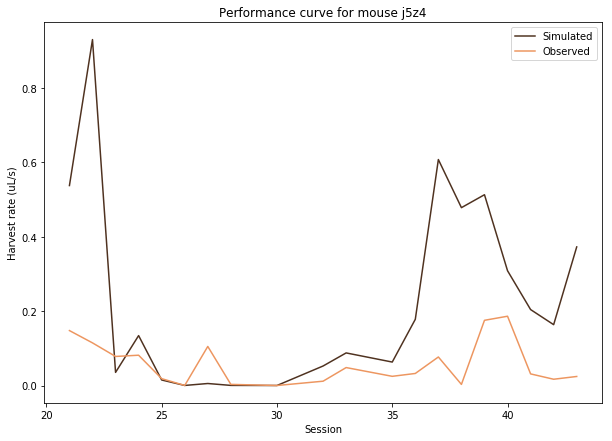

In [312]:
# Make figure, axes
fig, ax = plt.subplots(figsize=(10, 7))
#fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot harvest rates for simulation vs. observed behavior
_ = ax.plot(training_days, harvest_rate_sim, label='Simulated', color=cmap(0.25))
_ = ax.plot(training_days, harvest_rate_obs, label='Observed', color=cmap(0.75))
_ = ax.set_xlabel('Session')
_ = ax.set_ylabel('Harvest rate (uL/s)')
_ = ax.set_title('Performance curve for mouse %s' % mouse_id)
_ = ax.legend()

# Plot difference between two
#_ = ax[1].plot(training_days, harvest_rate_obs-harvest_rate_sim, label='Diff')
#_ = ax[1].set_xlabel('Session')
#_ = ax[1].set_ylabel('Harvest rate (uL/s)')
#_ = ax[1].legend()

# Save figure
plt.savefig(results_dir + 'sim_vs_obs_performance_curves.png')

### Analyze best time windows within sessions

#### Best time window

In [313]:
# Settings
window_size = 300 # seconds

# Placeholders
t_window = np.zeros([len(filelist), 2]) # best window
r_window = np.zeros(len(filelist)) # total reward in best window
tt, r_bins = [], [] # for plotting

# Calculate best time window in each session
for i in range(len(filelist)):
    with h5py.File(filelist[i]) as f:
        # Get trial timestamps (seconds)
        try:
            t_trial = (f['UntitledTrialStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
        
        except KeyError as err:
            print('Skipping file %s: trials are not timestamped.' % filelist[i])
            t_window[i] = [np.nan, np.nan]
            r_window[i] = np.nan
            tt.append([np.nan])
            r_bins.append([np.nan])
            continue
            
        # Calculate reward over session
        r_trial_ = f['UntitledRewarduL']['Data'][0, :]
        result_trial = f['UntitledTrialResult']['Data'][0, :]
        r_trial = ((result_trial == 0) + (result_trial == 3)) * r_trial_

        # Create one-minute sliding window across session       
        t_total = f['UntitledWheelTime']['Data'][0, -1] # last timestamp
        tt_ = np.arange(0, int(t_total), 60) # one-minute increments

        # Create array of shape [start_time, trial_idx], where each element
        # represents (start_time < t_trial[trial_idx] < start_time + window_size)
        #if len(t_trial) == len(r_trial) + 1:
        #    t_trial = t_trial[:-1]
        trial_bins = ( (t_trial[np.newaxis, :] > tt_[:, np.newaxis])
                       *(t_trial[np.newaxis, :] < tt_[:, np.newaxis] + window_size) )

        # Find time window with most reward
        try:
            r_bins_ = trial_bins * r_trial[np.newaxis, :] # broadcasted across start times
            tt_max_idx = np.argmax(np.sum(r_bins_, axis=1))
            t_window[i] = [tt_[tt_max_idx], tt_[tt_max_idx]+window_size]
            r_window[i] = np.max(np.sum(r_bins_, axis=1))
            tt.append(tt_)
            r_bins.append(r_bins_)
            
        except ValueError as err:
            print('Skipping file %s: trial and reward shapes do not match.' % filelist[i])
            t_window[i] = [np.nan, np.nan]
            r_window[i] = np.nan
            tt.append([np.nan])
            r_bins.append([np.nan])
            continue

# Save harvest rate of best window
harvest_rate_win = r_window / window_size

Skipping file Z:\James\data\ChamberC\9-10-18\j5z4_d23_2018_09_10_11_25_47.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberB\9-14-18\j5z4_d27_2018_09_14_09_32_16.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberC\9-24-18\j5z4_d33_2018_09_24_09_58_01.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberB\9-27-18\j5z4_d36_2018_09_27_14_49_20.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberB\9-28-18\j5z4_d37_2018_09_28_13_11_17.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberC\10-2-18\j5z4_d39_2018_10_02_11_01_42.mat: trial and reward shapes do not match.
Skipping file Z:\James\data\ChamberB\10-3-18\j5z4_d40_2018_10_03_15_38_01.mat: trial and reward shapes do not match.


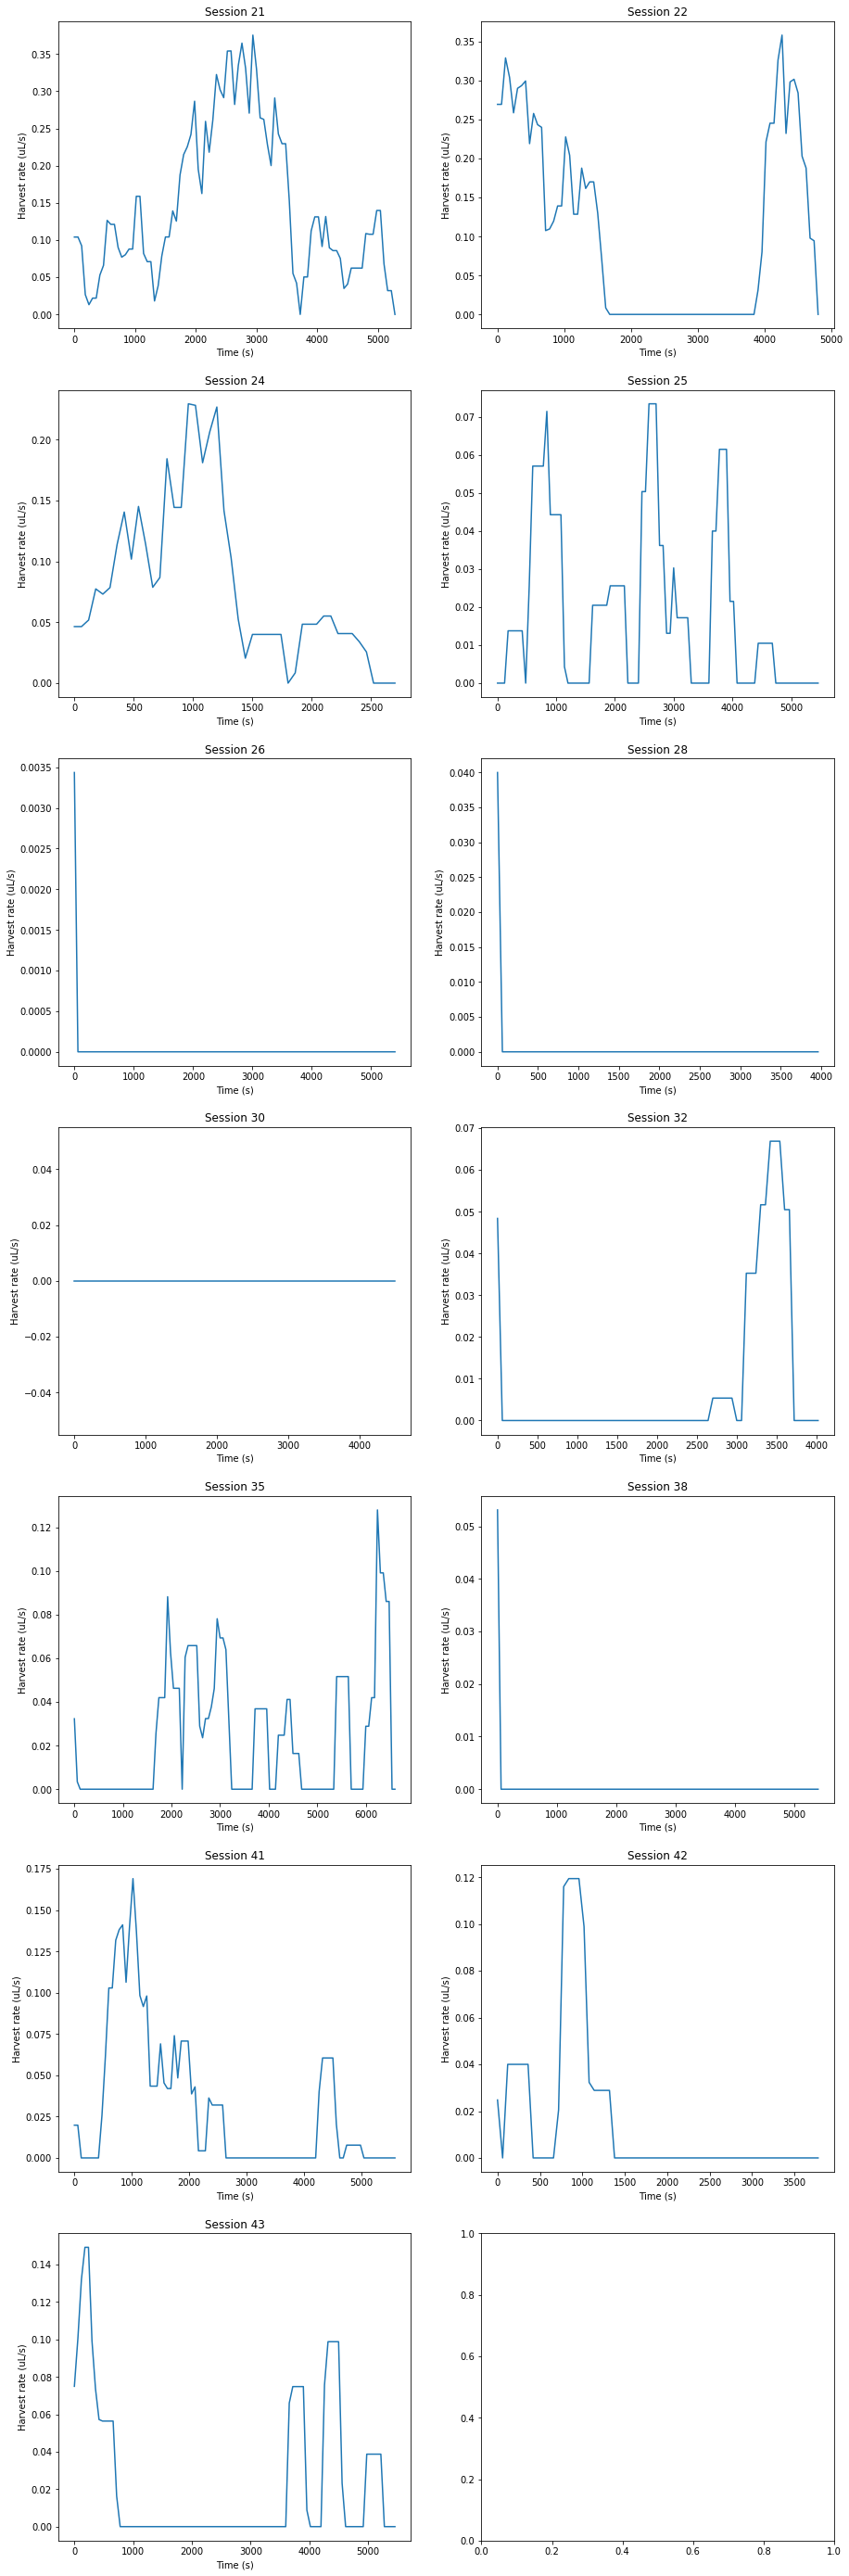

In [314]:
# Determine which sessions to plot
plot_idx = np.zeros(len(filelist), dtype=np.bool)
for i, rb in enumerate(r_bins):
    if not np.isnan(r_bins[i]).all():
        plot_idx[i] = True

# Plot harvest rate over sliding windows
fig, ax = plt.subplots(np.sum(plot_idx)//2+1, 2, figsize=(15, 50))
for i, j in enumerate(np.argwhere(plot_idx).flatten()):
    _ = ax[i//2, i%2].plot(tt[j], np.sum(r_bins[j], axis=1)/window_size)
    _ = ax[i//2, i%2].set_title('Session %d' % (training_days[j]))
    _ = ax[i//2, i%2].set_xlabel('Time (s)')
    _ = ax[i//2, i%2].set_ylabel('Harvest rate (uL/s)')

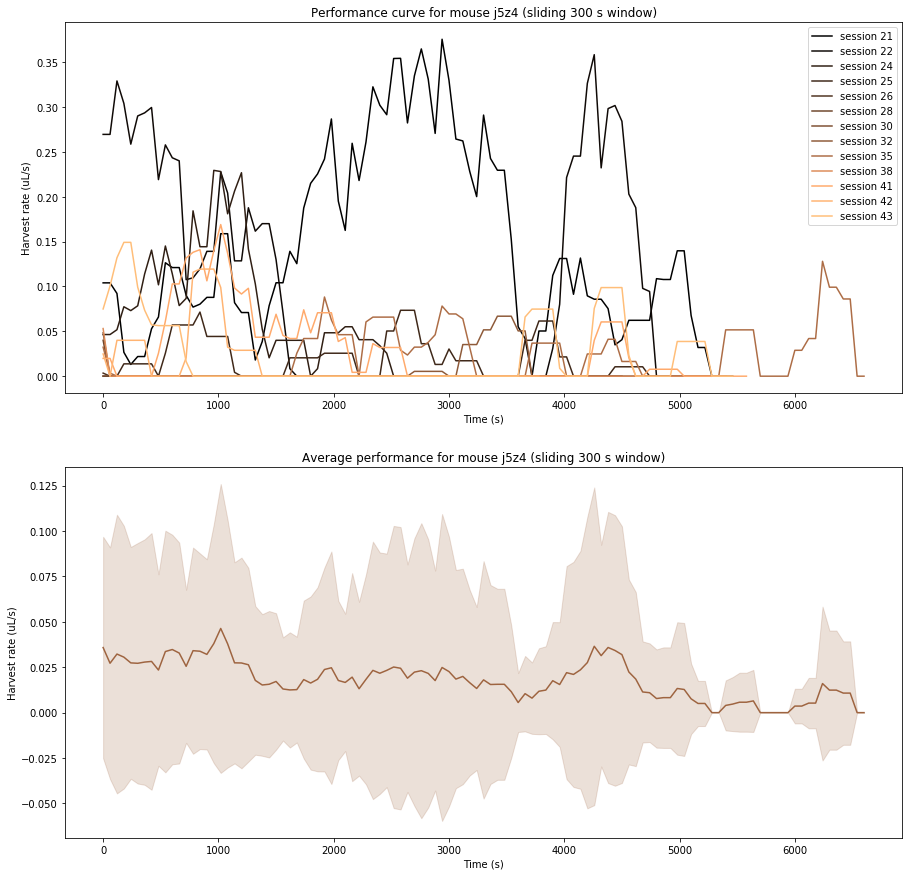

In [315]:
# Plot above in one figure
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
cmap = plt.get_cmap('copper')

# Plot individual sessions
for j in np.argwhere(plot_idx).flatten():
    _ = ax[0].plot(tt[j], 
                np.sum(r_bins[j], axis=1)/window_size, 
                label='session %d' % training_days[j],
                color=cmap(j/len(plot_idx)))

ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Harvest rate (uL/s)')
ax[0].set_title('Performance curve for mouse %s (sliding %d s window)' % (mouse_id, window_size))
ax[0].legend()

# Find longest session
len_max = 0
idx_max = 0
for i, tt_ in enumerate(tt):
    if len(tt_) > len_max:
        len_max = len(tt_)
        idx_max = i

# Calculate harvest rates over windows
hr_bin = np.zeros([len(plot_idx), len_max])
for i, j in enumerate(np.argwhere(plot_idx).flatten()):
    hr_bin[i, :len(tt[j])] = np.sum(r_bins[j], axis=1)/window_size
    hr_bin[i, len(tt[j]):] = -1

# Determine harvest rate mean and std for each window
hr_bin_mean = np.zeros(len_max)
hr_bin_std = np.zeros(len_max)
for i in range(len_max):
    hr_bin_i = hr_bin[:, i]
    hr_bin_mean[i] = np.mean(hr_bin_i[hr_bin_i >= 0])
    hr_bin_std[i] = np.std(hr_bin_i[hr_bin_i >= 0])

# Plot average session
ax[1].plot(tt[idx_max], hr_bin_mean, color=cmap(0.5))
ax[1].fill_between(tt[idx_max],
                   y1=hr_bin_mean-hr_bin_std, 
                   y2=hr_bin_mean+hr_bin_std, 
                   alpha=0.2,
                   color=cmap(0.5))
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Harvest rate (uL/s)')
ax[1].set_title('Average performance for mouse %s (sliding %d s window)' % (mouse_id, window_size))

# Save figure
plt.savefig(results_dir + 'obs_performance_curves_%ds.png' % window_size)

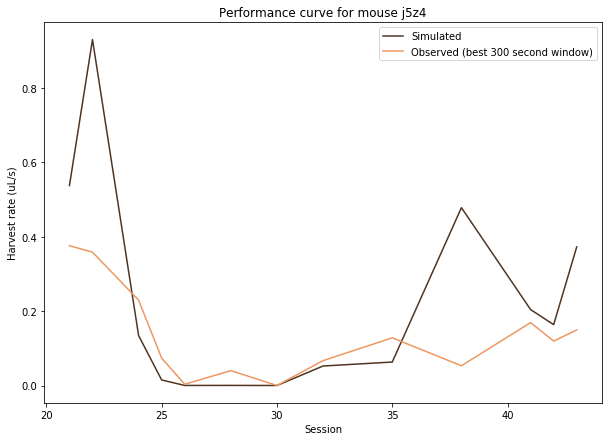

In [316]:
# Make figure, axes
#fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig, ax = plt.subplots(figsize=(10, 7))
plot_idx = np.argwhere(np.invert(np.isnan(harvest_rate_win))).flatten()

# Plot harvest rates for simulation vs. observed behavior
_ = ax.plot(training_days[plot_idx], harvest_rate_sim[plot_idx], label='Simulated', color=cmap(0.25))
#_ = ax.plot(training_days[plot_idx], harvest_rate_obs[plot_idx], label='Observed', color=cmap(0.5))
_ = ax.plot(training_days[plot_idx], harvest_rate_win[plot_idx], 
            label='Observed (best %d second window)' % window_size, color=cmap(0.75))
_ = ax.set_xlabel('Session')
_ = ax.set_ylabel('Harvest rate (uL/s)')
_ = ax.set_title('Performance curve for mouse %s' % mouse_id)
_ = ax.legend()

# Plot difference between two
#_ = ax[1].plot(training_days, harvest_rate_obs-harvest_rate_sim, label='Diff')
#_ = ax[1].scatter(training_days, harvest_rate_win-harvest_rate_sim, label='Diff (best %d second window)' % window_size)
#_ = ax[1].set_xlabel('Session')
#_ = ax[1].set_ylabel('Harvest rate (uL/s)')
#_ = ax[1].legend()

# Save figure
plt.savefig(results_dir + 'sim_vs_obs_performance_curves_%ds.png' % window_size)

#### Save time window data

In [317]:
# Create subfolder
d = results_dir + 'sliding_window\\'
if not os.path.isdir(d):
    os.mkdir(d)

# Save sessions
f = open(d + 'filelist.txt', 'w')
for filename in [filelist[i] for i in plot_idx]:
    f.write(filename + '\n')
f.close()
np.save(d + 'training_days', training_days[plot_idx])

# Save behavioral data
window_data = {'window_size': window_size,
               'tt': tt,
               'r_bins': r_bins,
               't_window': t_window,
               'r_window': r_window,
               'harvest_rate_win': harvest_rate_win,
               'harvest_rate_bin': hr_bin,
               'harvest_rate_mean': hr_bin_mean,
               'harvest_rate_std': hr_bin_std}
np.save(d + 'window_data', window_data)

### Analyze active periods of behavior
Unlike the above sliding time windows, these time windows will be selected on the basis of minimum performance metrics.

#### Determine sessions to analyze

In [318]:
# Specific sessions
#session_id = [45, 52, 55]
#idx = np.argwhere(np.isin(training_days, session_id)).flatten()

# Specific range
#idx = np.arange(len(filelist))
#session_id = training_days[idx]

# All sessions
idx = np.arange(len(filelist))
session_id = training_days[idx]

In [319]:
# Filter based on aligned timestamps
keep_idx_1 = np.ones(len(idx), dtype=np.bool)
for i, j in enumerate(idx):
    with h5py.File(filelist[j]) as f:
        # Get trial timestamps (seconds)
        t_trial = (f['UntitledTrialStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
        
        # Get results
        result_trial = f['UntitledTrialResult']['Data'][0, :]
        
        if len(t_trial) != len(result_trial):
            keep_idx_1[i] = False

print('Removed sessions ', training_days[idx[~keep_idx_1]], ' from analysis because trial timestamps ' \
      'are not aligned with trial results.')

keep_idx_2 = np.ones(len(idx), dtype=np.bool)
for i, j in enumerate(idx):
    with h5py.File(filelist[j]) as f:
        # Get patch start timestamps
        try:
            _ = f['UntitledPatchStartms']['Data'][0, :]
        
        except KeyError:
            keep_idx_2[i] = False

print('Removed sessions ', training_days[idx[~keep_idx_2]], ' from analysis because patch timestamps ' \
      'do not exist.')

keep_idx = np.logical_and(keep_idx_1, keep_idx_2)
idx = idx[keep_idx]
session_id = training_days[keep_idx]

Removed sessions  [23 27 33 36 37 39 40]  from analysis because trial timestamps are not aligned with trial results.
Removed sessions  [26 28 38]  from analysis because patch timestamps do not exist.


#### Harvest rate per patch

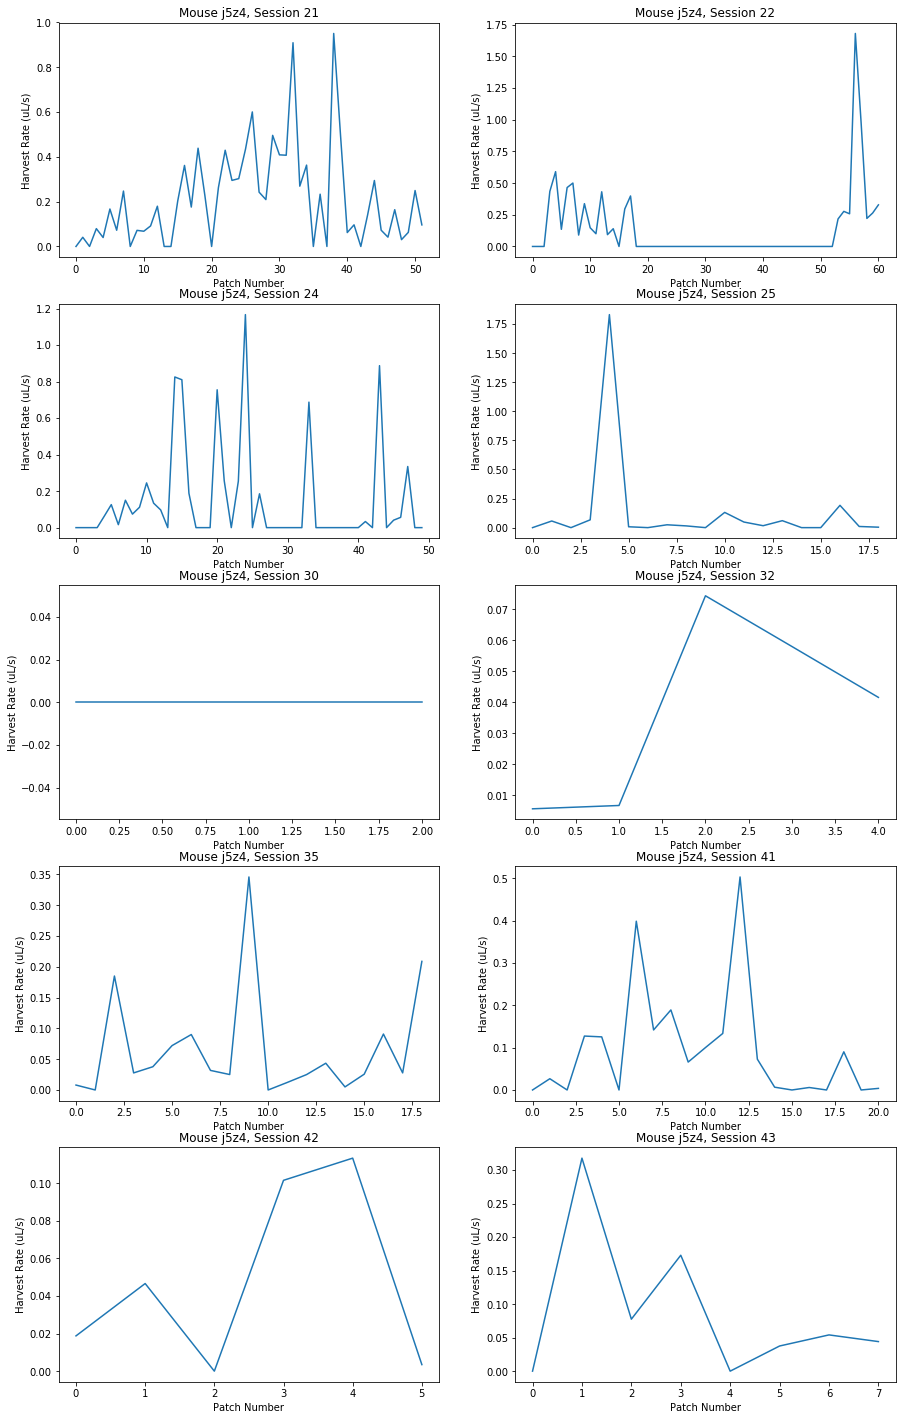

In [320]:
fig, ax = plt.subplots(max(len(idx)//2+(len(idx)%2==1), 1), 2, 
                       figsize=(15, 5*(max(len(idx)//2+(len(idx)%2==1), 1))))
for i, j in enumerate(idx):
    with h5py.File(filelist[j]) as f:
        # Get trial timestamps (seconds)
        t_trial = (f['UntitledTrialStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0

        # Get patch timestamps
        try:
            t_patch_start = (f['UntitledPatchStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
            patch_len = f['UntitledPatchTime']['Data'][0, :]
            t_patch_start = np.hstack([np.array([0.0,]), t_patch_start])
            t_patch_end = t_patch_start + patch_len
        except KeyError as err:
            print('Skipping file %s: Patch starts are not timestamped.' % filelist[j])
            r_patch = [np.nan]
            continue

        # Remove trials occurring too close to leaving patch
        dt = t_patch_end[np.newaxis, :] - t_trial[:, np.newaxis]
        dt[dt < 0] = np.inf # minimize only trials that occurred before patch end
        dt = np.amin(dt, axis=1)
        #t_trial = t_trial[dt > 0.1]
        
        # Bin trials into patches
        trial_patch = ( (t_trial[np.newaxis, :] > t_patch_start[:, np.newaxis])
                       *(t_trial[np.newaxis, :] < (t_patch_start + patch_len)[:, np.newaxis]) )

        # Calculate reward per trial
        r_trial_ = f['UntitledRewarduL']['Data'][0, :]
        result_trial = f['UntitledTrialResult']['Data'][0, :]
        r_trial = ((result_trial == 0) + (result_trial == 3)) * r_trial_

        # Calculate reward per patch
        try:
            r_patch = trial_patch * r_trial[np.newaxis, :] # broadcasted across start times
            r_patch = np.sum(r_patch, axis=1)
        except ValueError as err:
            print('Skipping file %s: trial and reward shapes do not match.' % filelist[j])
            #print(len(t_trial), len(r_trial))
            #print(float([u''.join(chr(c) for c in f['Settings']['Property']['SoftwareVersion'])][0]))
            r_patch = [np.nan]
            continue

    if len(idx) > 2:
        _ = ax[i//2, i%2].plot(r_patch/patch_len)
        _ = ax[i//2, i%2].set_title('Mouse %s, Session %d' % (mouse_id, training_days[j]))
        _ = ax[i//2, i%2].set_xlabel('Patch Number')
        _ = ax[i//2, i%2].set_ylabel('Harvest Rate (uL/s)')
    else:
        _ = ax[i].plot(r_patch/patch_len)
        _ = ax[i].set_title('Mouse %s, Session %d' % (mouse_id, training_days[j]))
        _ = ax[i].set_xlabel('Patch Number')
        _ = ax[i].set_ylabel('Harvest Rate (uL/s)')

if len(idx) == 1:
    ax[-1].axis('off')
elif (len(idx) % 2 == 1):
    ax[-1, 1].axis('off')

#### Determine inclusion criteria

The mouse likely has periods of engagement and periods of rest/sleep/disengagement over the course of any session. Rather than simulating the overall metrics (e.g. hit rate, false alarm rate), let's simulate the metrics that represent sliding time windows to reflect how it does within windows in which it is engaged. In order to do this, we must first determine which session(s) (and which parts of those sessions) to include for this analysis.

In [321]:
# Inclusion criteria
v_thresh = 0.02 # min velocity during interpatches
vf_sig = 0.6 # min fraction v_thresh is exceeded during interpatches
dp_sig = 0.5 # min d prime during patches

# Time window settings
filt_len = 2.0 # seconds
dt_bin = 300 # time bin (s)
dt_overlap = dt_bin//2 # overlap (s)

# Plot settings
plot_data = False

# Placeholders
t_sig = [] # time bins of significant activity, given by [...[t1, t2]...]
f_active = np.zeros(len(idx)) # percent time active
hit_rate_sig = [] # hit rate during significant time windows
fa_rate_sig = [] # fa rate during significant time windows
if plot_data:
    fig, ax = plt.subplots(len(idx), 3, figsize=(20, len(idx)*4))

for i, j in enumerate(idx):
    with h5py.File(filelist[j]) as f:
        ### Calculate trial bins ###
        # Get trial timestamps (seconds)
        t_trial = (f['UntitledTrialStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0

        # Determine last timestamp in analysis window
        t_patch_start = (f['UntitledPatchStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
        patch_len = f['UntitledPatchTime']['Data'][0, :]
        t_patch_start = np.hstack([np.array([0.0,]), t_patch_start])
        t_patch_end = t_patch_start + patch_len
        t_total = t_patch_end[-1]

        # Bin trials results by time window
        tt_ = np.arange(dt_bin//2, int(t_total), dt_bin - dt_overlap)
        trial_bins = ( (t_trial[np.newaxis, :] > tt_[:, np.newaxis] - dt_bin//2)
                       *(t_trial[np.newaxis, :] < tt_[:, np.newaxis] + dt_bin//2) )
        results = f['UntitledTrialResult']['Data'][0, :] + 1 # shift indices by 1
        results_bins = trial_bins * results[np.newaxis, :]

        ### Calculate performance metrics (patch engagement) ###
        # Indices (right-shifted by 1): hit=1, miss=2, fa=3, catch=4, n/a=5
        # For invalid bins (zero number of trial types), default value is zero.
        # Hit rate
        hit_rate = np.zeros(len(tt_))
        n_targets = np.sum((results_bins == 1) + (results_bins == 2), axis=1)
        hit_idx = np.argwhere(n_targets > 0).flatten()
        hit_rate[hit_idx] = np.sum((results_bins == 1), axis=1)[hit_idx] / n_targets[hit_idx]

        # False alarm rate    
        struct = f['Settings']['Property']
        bin_width = float([u''.join(chr(c) for c in struct['SoundConfigurationToneCloudConfigTimeBinWidthms'])][0])
        dt_nc = f['UntitledNCTimechord']['Data'][0, :] * bin_width / 1000.0
        target_duration = float([u''.join(chr(c) for c in struct['SoundConfigurationTargetSoundConfigTargetDurationsec'])][0])
        dt_nc_bins = trial_bins * dt_nc[np.newaxis, :]
        n_cr = np.sum((dt_nc_bins / target_duration).astype(np.int32), axis=1) # or reaction time?
        n_fa = np.sum((results_bins == 3), axis=1)
        fa_rate = n_fa / (n_fa + n_cr)

        # d prime, bias
        hit_rate_ = np.maximum(np.minimum(hit_rate, 0.99), 0.01); # avoids z = +/-inf
        fa_rate_ = np.maximum(np.minimum(fa_rate, 0.99), 0.01); # avoids z = +/-inf
        z_hit_rate = norm.ppf(hit_rate_, loc=0.0, scale=1.0)
        z_fa_rate = norm.ppf(fa_rate_, loc=0.0, scale=1.0)
        dp = z_hit_rate - z_fa_rate
        c = -(z_hit_rate + z_fa_rate) / 2 # note negative sign

        ### Calculate time walking (interpatch engagement) ###
        # Calculate smoothed velocity trace
        t_v = f['UntitledWheelTime']['Data'][0, :]
        v = f['UntitledWheelSpeed']['Data'][0, :]
        dt_v = np.mean(np.diff(t_v))
        filt_pts = int(filt_len / dt_v)
        filt = np.zeros(2*filt_pts)
        filt[0:filt_pts] = 1.0 / filt_pts
        v_smooth = np.convolve(v, filt, mode='same')

        # Determine which wheel time indices correspond to interpatches
        #dt_ip = f['UntitledInterPatchTime']['Data'][0, :]
        dt_ip = t_patch_start[1:] - t_patch_end[:-1]
        idx_ip = ( (t_v[np.newaxis, :] > t_patch_end[:-1, np.newaxis])
                   *(t_v[np.newaxis, :] < (t_patch_end[:-1] + dt_ip)[:, np.newaxis]) )
        idx_ip = np.sum(idx_ip, axis=0).astype(np.bool) # collapse across all interpatches

        # For each time bin, determine percent time walking while in interpatch(es)
        v_bins = ( (t_v[np.newaxis, :] > tt_[:, np.newaxis] - dt_bin//2)
                   *(t_v[np.newaxis, :] < tt_[:, np.newaxis] + dt_bin//2) )
        v_bins = (v_bins * v_smooth[np.newaxis, :]) * idx_ip[np.newaxis, :]
        vf = np.sum(v_bins > v_thresh, axis=1) / np.sum(v_bins > 0, axis=1)

        ### Determine time windows of significant activity ###
        # Determine indices of active time bins
        tt_sig = (dp > dp_sig) * (vf > vf_sig)
        
        # Save hit and false alarm rates during active time bins
        hit_rate_sig.append(hit_rate[tt_sig])
        fa_rate_sig.append(fa_rate[tt_sig])
        
        # Convert active time bins to array of time points
        idx_sig = (tt_sig.astype(np.int32) + np.roll(tt_sig.astype(np.int32), -1))[:-1]
        idx_sig = np.argwhere(idx_sig == 1).flatten()
        if tt_sig[0]:
            idx_sig = np.insert(idx_sig, 0, 0)
        if tt_sig[-1]:
            idx_sig = np.append(idx_sig, len(tt_)-1)
        t_sig_i = tt_[idx_sig].reshape([-1, 2])
        #t_sig_i += np.array([-dt_bin//2, dt_bin//2])
        t_sig.append(t_sig_i)
        f_active[i] = np.sum(np.diff(t_sig_i)) / t_total
    
        ### Plot determination of activity over session ###
        if plot_data:
            # Plot sdt metrics
            l1 = ax[i, 0].plot(tt_, hit_rate, label='hit rate')
            l2 = ax[i, 0].plot(tt_, fa_rate, label='fa rate')
            ax2 = ax[i, 0].twinx()
            for _ in range(2):
                next(ax2._get_lines.prop_cycler)
            l3 = ax2.plot(tt_, dp, label='d`')
            l4 = ax2.plot(tt_, c, label='c')
            lns = l1 + l2 + l3 + l4
            labs = [l.get_label() for l in lns]
            _ = ax[i, 0].legend(lns, labs)

            # Plot velocity traces
            _ = ax[i, 1].plot(t_v, v, label='velocity')
            _ = ax[i, 1].plot(t_v, v_smooth, label='velocity (smoothed)')
            _ = ax[i, 1].legend()

            # Plot windows of significant activity
            l1 = ax[i, 2].plot(tt_, dp, label='d`')
            ax2 = ax[i, 2].twinx()
            for _ in range(1):
                next(ax2._get_lines.prop_cycler)
            l2 = ax2.plot(t_v, v_smooth, label='v (smoothed)')
            for k in range(t_sig_i.shape[0]):
                l3 = ax[i, 2].axvspan(*t_sig_i[k], facecolor='g', alpha=0.2)
            lns = l1 + l2
            labs = [l.get_label() for l in lns]
            _ = ax[i, 2].legend(lns, labs)

C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)
C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in greater
C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


#### Limit analysis to included time windows

##### Re-run simulations based on active windows only

In [322]:
# Simulation parameters
num_steps_per_sim= 1000
num_sims_per_value = 20

# Animal parameters
velocity = None # take median running velocity of each session
decision_type = 'reward'
decision_val = np.arange(2*2, 12*2+1) / 2
sdt_metrics = 'distribution'
sdt_bins = np.arange(21)/20

# Run simulations
data = simulate_sessions([filelist[i] for i in idx],
                         num_steps_per_sim,
                         num_sims_per_value,
                         velocity=velocity,
                         decision_type=decision_type,
                         decision_val=decision_val,
                         sdt_metrics=sdt_metrics,
                         sdt_bins=sdt_bins,
                         hit_rate_dist=hit_rate_sig,
                         fa_rate_dist=fa_rate_sig,
                         session_names=[training_days[i] for i in idx],
                         verbose=True)
sim_data = data['sim_data']
env_data = data['env_data']

Simulating rodent session 21...
Simulating rodent session 22...
Simulating rodent session 24...
Simulating rodent session 25...
Simulating rodent session 30...
Simulating rodent session 32...
Simulating rodent session 35...
Simulating rodent session 41...
Simulating rodent session 42...
Simulating rodent session 43...
Done.


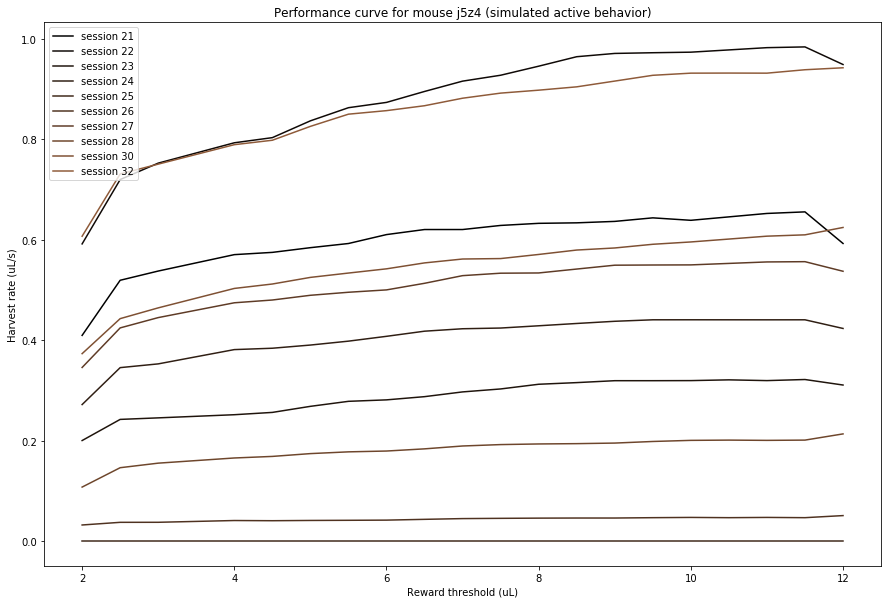

In [323]:
# Placeholders
harvest_rate_sim = np.zeros(len(idx))
r_thresh_sim = np.zeros(len(idx))

# Plot setup
fig, ax = plt.subplots(figsize=(15, 10))
cmap = plt.get_cmap('copper')

for i in range(len(idx)):
    # Calculate harvest rate mean and std
    mean = np.mean(sim_data['r_total'][i, :, :]/sim_data['t_total'][i, :, :], axis=1)
    std = np.std(sim_data['r_total'][i, :, :]/sim_data['t_total'][i, :, :], axis=1)

    # Smooth curve with 1D median filter
    mean_smooth = np.zeros(mean.shape)
    n = 10 # filter size
    mean_smooth[0] = mean[0] # anchor at ends
    mean_smooth[-1] = mean[-1] # anchor at ends
    for j in range(1, mean.shape[0]-1):
        mean_smooth[j] = np.median(mean[max(j-n//2, 0):min(j+n//2, mean.shape[0]-1)])
    harvest_rate_sim[i] = np.max(mean_smooth)
    r_thresh_sim[i] = decision_val[np.argmax(mean_smooth)]

    # Plot results
    #p_mean = ax.plot(decision_val, mean)
    #p_std = ax.fill_between(decision_val, mean-std, mean+std, alpha=0.2)
    p_mean_smooth = ax.plot(decision_val, 
                            mean_smooth, 
                            label='session %d' % (training_days[i]),
                            color=cmap(i/len(filelist)))
        
p_xlabel = ax.set_xlabel('Reward threshold (uL)')
p_ylabel = ax.set_ylabel('Harvest rate (uL/s)')
p_title = ax.set_title('Performance curve for mouse %s (simulated active behavior)' % mouse_id)
l = ax.legend()

# Save plot
plt.savefig(results_dir + 'sim_performance_curves_active.png')

##### Calculate observed performance and decision criteria

In [324]:
# Placeholders
harvest_rate_sig = np.zeros(len(idx))
dt_leave = []
r_last = []

for i, j in enumerate(idx):
    with h5py.File(filelist[j]) as f:
        # Get trial and patch end timestamps (seconds)
        t_trial = (f['UntitledTrialStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
        t_patch_end = (f['UntitledPatchEndms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0

        # Calculate reward per trial
        r_trial_ = f['UntitledRewarduL']['Data'][0, :]
        result_trial = f['UntitledTrialResult']['Data'][0, :]
        r_trial = ((result_trial == 0) + (result_trial == 3)) * r_trial_

        # Limit scope to rewarded trials
        t_trial = t_trial[r_trial > 0.0]
        r_trial = r_trial[r_trial > 0.0]

        # Limit scope to trials inside time window(s)
        idx_sig = ( (t_trial[np.newaxis, :] > t_sig[i][:, 0][:, np.newaxis])
                   *(t_trial[np.newaxis, :] < t_sig[i][:, 1][:, np.newaxis]) )
        idx_sig = np.sum(idx_sig, axis=0).astype(np.bool) # collapse over all time bins
        t_trial = t_trial[idx_sig]
        r_trial = r_trial[idx_sig]

        # Calculate harvest rate
        harvest_rate_sig[i] = np.sum(r_trial) / np.sum(np.diff(t_sig[i]))

        ### Calculate leaving criteria per patch based on last rewarded trial ###
        # Find patch end times within significant time window(s)
        idx_sig = ( (t_patch_end[np.newaxis, :] > t_sig[i][:, 0][:, np.newaxis])
                   *(t_patch_end[np.newaxis, :] < t_sig[i][:, 1][:, np.newaxis]) )
        idx_sig = np.sum(idx_sig, axis=0).astype(np.bool) # collapse over all time bins
        t_patch_end_ = t_patch_end[idx_sig]

        # Find all rewarded trials before patch end times
        idx_last = t_trial[np.newaxis, :] < t_patch_end_[:, np.newaxis]

        # Remove patches with no rewarded trials before end
        t_patch_end_ = t_patch_end_[np.sum(idx_last, axis=1) > 0]
        idx_last = idx_last[np.sum(idx_last, axis=1) > 0, :]

        # Find index of last rewarded trial before patch end
        if idx_last.size > 0:
            idx_last = idx_last.shape[1] - np.argmax(idx_last[:, ::-1], axis=1) - 1 # reverse row order to get last occurence

        # Remove patches with no rewarded trials in them
        idx_last, idx_valid = np.unique(idx_last, return_index=True)
        t_patch_end_ = t_patch_end_[idx_valid]

        # Determine volume of last rewarded trial and time to leaving decision
        t_last = t_trial[idx_last]
        dt_leave.append(t_patch_end_ - t_last)
        r_last.append(r_trial[idx_last])

C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


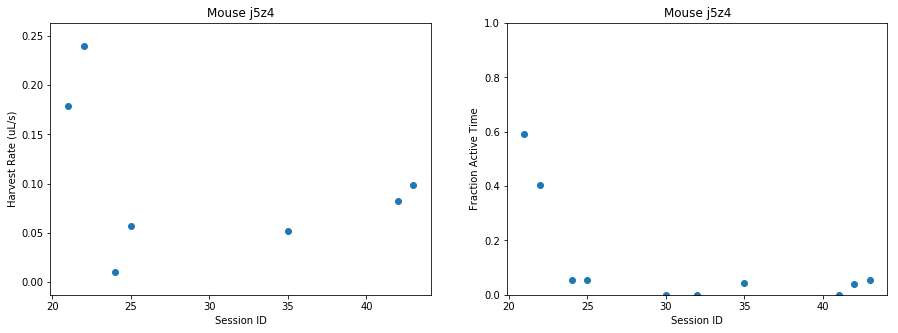

In [325]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot harvest rate across sessions
_ = ax[0].scatter(session_id, harvest_rate_sig)
_ = ax[0].set_title('Mouse %s' % mouse_id)
_ = ax[0].set_xlabel('Session ID')
_ = ax[0].set_ylabel('Harvest Rate (uL/s)')

# Plot fraction time active across sessions
_ = ax[1].scatter(session_id, f_active)
_ = ax[1].set_title('Mouse %s' % mouse_id)
_ = ax[1].set_xlabel('Session ID')
_ = ax[1].set_ylabel('Fraction Active Time')
_ = ax[1].set_ylim([0.0, 1.0])
    
# Save figure
plt.savefig(results_dir + 'performance_active.png')

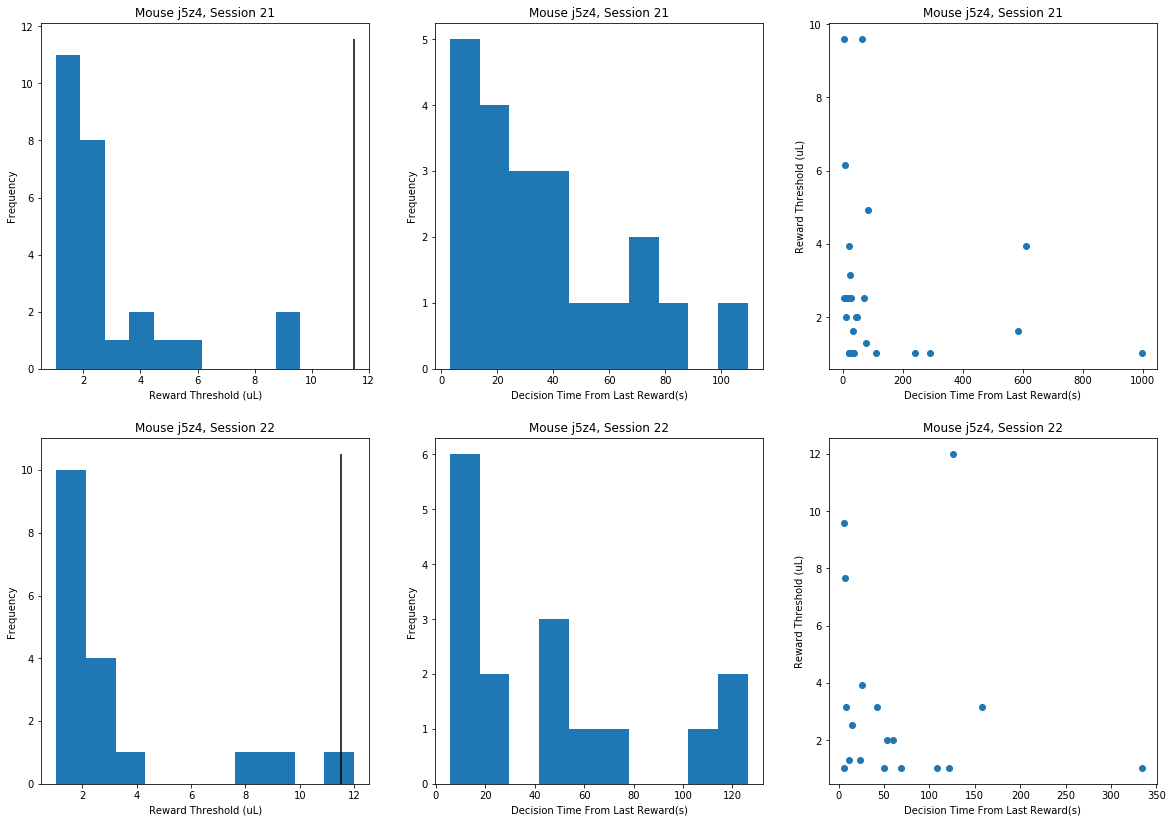

In [326]:
# Filter by percent time active
f_active_thresh = 0.1
plot_idx = idx[f_active > f_active_thresh]

# Make figures, axes
fig, ax = plt.subplots(len(plot_idx), 3, 
                       figsize=(20, len(plot_idx)*7))

k = 0
for i, j in enumerate(idx):
    if j in plot_idx:
        # Plot histogram of last reward volume before leaving
        ax[k, 0].hist(r_last[i])
        ax[k, 0].vlines(r_thresh_sim[i], *ax[k, 0].get_ylim())
        ax[k, 0].set_title('Mouse %s, Session %d' % (mouse_id, training_days[j]))
        ax[k, 0].set_xlabel('Reward Threshold (uL)')
        ax[k, 0].set_ylabel('Frequency')

        # Plot histogram of time from last reward when leaving
        ax[k, 1].hist(dt_leave[i][dt_leave[i] < 150.0]) # ignore outliers
        ax[k, 1].set_title('Mouse %s, Session %d' % (mouse_id, training_days[j]))
        ax[k, 1].set_xlabel('Decision Time From Last Reward(s)')
        ax[k, 1].set_ylabel('Frequency')
        
        # Combine two into scatter plot
        ax[k, 2].scatter(dt_leave[i], r_last[i])
        ax[k, 2].set_title('Mouse %s, Session %d' % (mouse_id, training_days[j]))
        ax[k, 2].set_xlabel('Decision Time From Last Reward(s)')
        ax[k, 2].set_ylabel('Reward Threshold (uL)')
         
        k += 1

# Save figure
plt.savefig(results_dir + 'decision_criteria.png')

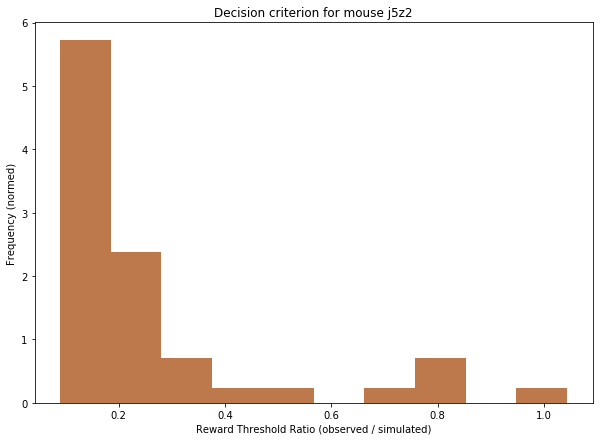

In [327]:
# Plot difference between observed and simulated reward threshold across active sessions
# during significant time windows
n = 0
r_thresh_ratio_ = []
for i, j in enumerate(idx):
    if j in plot_idx:
        r_thresh_ratio_.append(r_last[i] / r_thresh_sim[i])
        n += len(r_last[i])

r_thresh_ratio = np.zeros(n)
j = 0
for i in range(len(r_thresh_ratio_)):
    r_thresh_ratio[j:j+len(r_thresh_ratio_[i])] = r_thresh_ratio_[i]
    j += len(r_thresh_ratio_[i])
r_thresh_ratio_ = None

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(r_thresh_ratio, density=True, color=cmap(0.60))
ax.set_title('Decision criterion for mouse j5z2')
ax.set_xlabel('Reward Threshold Ratio (observed / simulated)')
ax.set_ylabel('Frequency (normed)')
#ax.set_xlim(ax.get_xlim()[0], -ax.get_xlim()[0])
#ax.set_xlim(0.0, 4.0)

plt.savefig(results_dir + 'decision_criterion_diff.png')

#### Save analysis data of active periods

In [328]:
# Create subfolder
d = results_dir + 'active_window\\'
if not os.path.isdir(d):
    os.mkdir(d)

# Save sessions
filelist_sig = [filelist[i] for i in idx]
training_days_sig = training_days[idx]
f = open(d + 'filelist.txt', 'w')
for filename in filelist_sig:
    f.write(filename + '\n')
f.close()
np.save(d + 'training_days', training_days_sig)
    
# Save simulation data
np.save(d + 'decision_val', decision_val)
np.save(d + 'sim_data', sim_data)
np.save(d + 'env_data', env_data)
np.save(d + 'harvest_rate', harvest_rate_sim)
np.save(d + 'r_thresh', r_thresh_sim)

# Write settings file
f = open(d + 'settings.txt', 'w')
f.write('Experiment params:\n')
f.write('Description: ' + exp_desc + '\n')
f.write('Steps per simulation = %d\n' % num_steps_per_sim)
f.write('Simulations per decision value = %d\n' % num_sims_per_value)
f.write('\nAnimal params:\n')
f.write('velocity = %s' % velocity)
f.write('decision_type = %s\n' % decision_type)
if isinstance(decision_val, np.ndarray):
    f.write('decision_val = %s\n' % 
            ('[' + ', '.join([str(dv) for dv in decision_val]) + ']'))
else:
    f.write('decision_val = %.2f\n' % decision_val)
f.write('sdt_metrics = %s' % sdt_metrics)
f.close()

# Save behavioral data
active_data = {'t_sig': t_sig,
               'f_active': f_active,
               'hit_rate': hit_rate_sig,
               'fa_rate': fa_rate_sig,
               'harvest_rate': harvest_rate_sig,
               'dt_leave': dt_leave,
               'r_last': r_last}
np.save(d + 'active_data', active_data)

### Analyze walking statistics
From here on, we will limit analysis to analyzable sessions (idx above).

In [329]:
def remove_outliers(a, thresh=2.0):
    mean = np.mean(a)
    std = np.std(a)
    return a[np.logical_and(a > mean-thresh*std, a < mean+thresh*std)]

In [330]:
def flatten_list(a):
    """Converts list of arrays into single 1D array"""
    # Determine total number of elements in list
    n = 0
    for a_i in a:
        n += a_i.size
        
    # Build flattened array
    a_flat = np.zeros(n)
    j = 0
    for i, a_i in enumerate(a):
        a_flat[j:j+a_i.size] = a_i.flatten()
        j += a_i.size
    
    return a_flat

#### Distribution of walk- and still-bouts

In [331]:
# Settings
wheel_circumference = 60 # cm
#v_start = 0.05 # threshold from standing to running
v_stop = 0.02 # threshold from running to standing 

# Placeholders
dt_run = []
dx_run = []
dt_still = []

for i in range(len(filelist_sig)):
    with h5py.File(filelist_sig[i]) as f:
        print('Processing session %d of %d...' % (training_days_sig[i], training_days_sig[-1]))
        
        # Get experiment data
        t_v = f['UntitledWheelTime']['Data'][0, :]
        v = f['UntitledWheelSpeed']['Data'][0, :]
        x = f['UntitledAngularPosition']['Data'][0, :] / 360 * wheel_circumference
        v_start = f['Settings']['Property']['SoundConfigurationRunConfigVThresholdms']
        v_start = float([u''.join(chr(c) for c in v_start)][0])
        
        # Calculate smoothed velocity trace
        dt_v = np.mean(np.diff(t_v))
        filt_pts = int(filt_len / dt_v)
        filt = np.zeros(2*filt_pts)
        filt[0:filt_pts] = 1.0 / filt_pts
        v_smooth = np.convolve(v, filt, mode='same')
        
        # Determine start and stop times (just do a for loop, whatever)
        t_start = []
        x_start = []
        t_stop = []
        x_stop = []
        is_running = v_smooth[0] > v_start
        for j in range(len(v_smooth)):
            # Start running
            if not is_running and v_smooth[j] > v_start:
                is_running = True
                t_start.append(t_v[j])
                x_start.append(x[j])
                
            # Stop running
            elif is_running and v_smooth[j] < v_stop:
                is_running = False
                t_stop.append(t_v[j])
                x_stop.append(x[j])
        
        # Calculate walk- and still-bout durations
        t_start = np.array(t_start)
        x_start = np.array(x_start)
        t_stop = np.array(t_stop)
        x_stop = np.array(x_stop)
        if v_smooth[0] < v_start: # still at beginning
            num_run_i = len(t_stop)
            num_still_i = len(t_start) - 1
            dt_run.append(t_stop[:num_run_i] - t_start[:num_run_i])
            dx_run.append(x_stop[:num_run_i] - x_start[:num_run_i])
            dt_still.append(t_start[1:] - t_stop[:num_still_i])
        else: # running at beginning
            num_run_i = len(t_stop) - 1
            num_still_i = len(t_start)
            dt_run.append(t_stop[1:] - t_start[:num_run_i])
            dx_run.append(x_stop[1:] - x_start[:num_run_i])
            dt_still.append(t_start[:num_still_i] - t_stop[:num_still_i])

print('Done.')

Processing session 21 of 43...
Processing session 22 of 43...
Processing session 24 of 43...
Processing session 25 of 43...
Processing session 30 of 43...
Processing session 32 of 43...
Processing session 35 of 43...
Processing session 41 of 43...
Processing session 42 of 43...
Processing session 43 of 43...
Done.


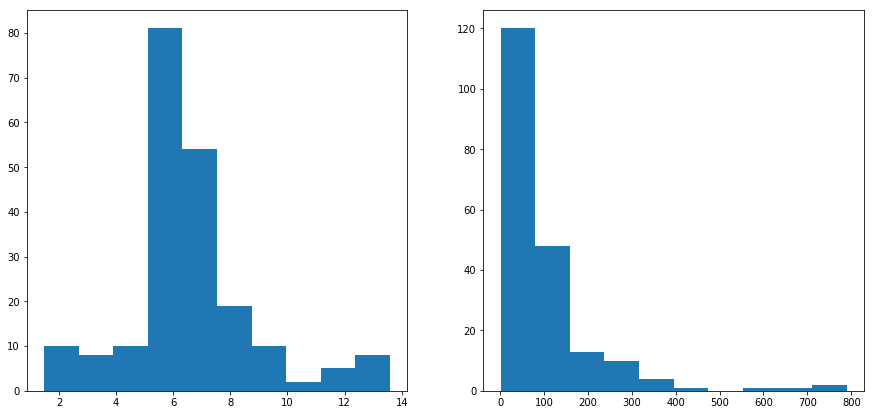

In [332]:
# Reorganize data in flattened array over all sessions
dt_run_all = flatten_list(dt_run)
dx_run_all = flatten_list(dx_run)
dt_still_all = flatten_list(dt_still)

# Plot global distribution
thresh = 2.5
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
[n_run, bins_run, _] = ax[0].hist(remove_outliers(dt_run_all, thresh=thresh))
[n_still, bins_still, _] = ax[1].hist(remove_outliers(dt_still_all, thresh=thresh));

#### Empirical interpatch distance
How do the distances mice run between patches compare to the environment parameter, which dictates the minimum interpatch distance?

##### Method 1: Calculate from known walk-bout data

In [333]:
dx_ip = []
for i, j in enumerate(idx):
    with h5py.File(filelist[j]) as f:
        print('Processing session %d of %d...' % (training_days_sig[i], training_days_sig[-1]))
        
        # Get interpatch distance
        d_interpatch = f['Settings']['Property']['SoundConfigurationRunConfigInterPatchDistcm']
        d_interpatch = float([u''.join(chr(c) for c in d_interpatch)][0])
        
        # Build interpatch distances from walk-bout info
        dx_ip_ = []
        dx = 0
        for dx_ in dx_run[i]:
            dx += dx_
            if dx >= d_interpatch:
                dx_ip_.append(dx)
                dx = 0
        
        dx_ip.append(np.asarray(dx_ip_))

Processing session 21 of 43...
Processing session 22 of 43...
Processing session 24 of 43...
Processing session 25 of 43...
Processing session 30 of 43...
Processing session 32 of 43...
Processing session 35 of 43...
Processing session 41 of 43...
Processing session 42 of 43...
Processing session 43 of 43...


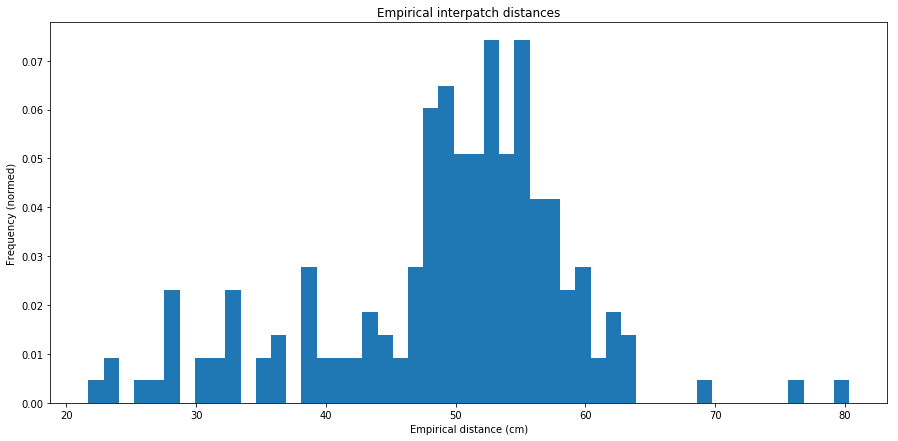

In [334]:
# Consolidate in single array
dx_ip_all = flatten_list(dx_ip)

# Plot distribution
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(remove_outliers(dx_ip_all), bins=50, density=True)
ax.set_title('Empirical interpatch distances')
ax.set_xlabel('Empirical distance (cm)')
ax.set_ylabel('Frequency (normed)');

##### Method 2: Align with patch/interpatch timestamps
This is probably not accurate, given that we're assuming the hardware patch/interpatch timestamps are roughly aligned with the software wheel/position timestamps. We can qualitatively estimate the accuracy of our calculation by plotting the velocity traces for the defined interpatch time windows--we should see it crossing the run threshold at the beginning and the walk threshold at the end.

In [335]:
# Settings
wheel_circumference = 60 # cm
velocity_window_start = -5.0 # seconds relative to start of interpatch window
check_estimate = True

# Placeholders
dx_ip_2 = []
v_ip = []
t_ip = []
f_err = []

for i, j in enumerate(idx):
    with h5py.File(filelist[j]) as f:
        print('Processing session %d of %d...' % (training_days_sig[i], training_days_sig[-1]))
        
        # Get wheel positions and timestamps
        x = f['UntitledAngularPosition']['Data'][0, :] / 360 * wheel_circumference
        t = f['UntitledWheelTime']['Data'][0, :]
        
        # Get patch timestamps
        t_patch_start = (f['UntitledPatchStartms']['Data'][0, :] - f['UntitledAIStartms']['Data'][0])/1000.0
        patch_len = f['UntitledPatchTime']['Data'][0, :]
        t_patch_start = np.hstack([np.array([0.0,]), t_patch_start])
        t_patch_end = t_patch_start + patch_len

        # Determine which wheel time indices correspond to interpatches
        #dt_ip = f['UntitledInterPatchTime']['Data'][0, :]
        dt_ip = t_patch_start[1:] - t_patch_end[:-1]
        num_ip = len(dt_ip)
        idx_ip = ( (t[np.newaxis, :] > t_patch_end[:-1, np.newaxis])
                   *(t[np.newaxis, :] < (t_patch_end[:-1] + dt_ip)[:, np.newaxis]) )
        _, idx_start = np.unique(np.argwhere(idx_ip)[:, 0], return_index=True) 
        idx_start = np.argwhere(idx_ip)[idx_start, 1] # first index in interpatches
        idx_per_patch = np.sum(idx_ip, axis=1)
        idx_end = idx_start + idx_per_patch - 1 # last index in interpatches
        dx_ip_2_ = x[idx_end] - x[idx_start]
        dx_ip_2.append(dx_ip_2_)
        
        # Get velocity trace interpatch
        v = f['UntitledWheelSpeed']['Data'][0, :] * 100
        for k in range(num_ip):
            idx_ip_ = idx_ip[k]
            idx_0 = np.argwhere(idx_ip[k])[0, 0]
            idx_win = int(velocity_window_start / np.mean(np.diff(t)))
            idx_1 = min(idx_0, idx_0 + idx_win)
            idx_2 = max(idx_0, idx_0 + idx_win)  
            idx_ip_[idx_1:idx_2] = np.logical_not(idx_ip_[idx_1:idx_2])
            v_ip.append(v[idx_ip_])
            t_ip.append(t[idx_ip_] - t[idx_0])
            #v_ip.append(v[idx_ip[k]])
        
        # Double check to make sure compatible distance
        if check_estimate:
            v_mean = np.zeros(num_ip)
            for k in range(num_ip):
                v_mean[k] = np.mean(v[idx_ip[k]])
            dx_ip_est = dt_ip * v_mean
            f_err.append((dx_ip_2_ - dx_ip_est) / dx_ip_est)
            #print('Fractional error: %.3f +/- %.3f' % (np.mean(f_err[-1]), np.std(f_err[-1])))
            
if check_estimate:
    f_err = flatten_list(f_err)
    print('Overall fractional error: %.3f +/- %.3f' % (np.mean(f_err), np.std(f_err)))

Processing session 21 of 43...
Processing session 22 of 43...
Processing session 24 of 43...
Processing session 25 of 43...
Processing session 30 of 43...
Processing session 32 of 43...
Processing session 35 of 43...
Processing session 41 of 43...
Processing session 42 of 43...
Processing session 43 of 43...
Overall fractional error: 0.204 +/- 0.275


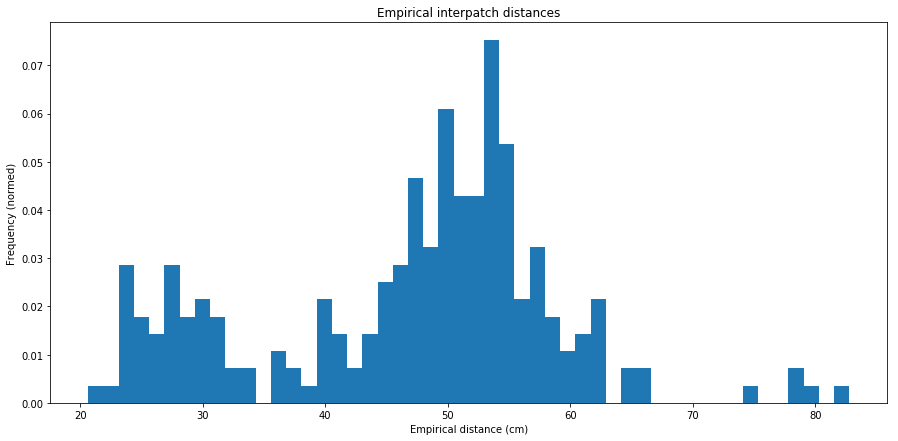

In [336]:
# Consolidate in single array
dx_ip_2_all = flatten_list(dx_ip_2)

# Plot distribution
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(remove_outliers(dx_ip_2_all), bins=50, density=True)
ax.set_title('Empirical interpatch distances')
ax.set_xlabel('Empirical distance (cm)')
ax.set_ylabel('Frequency (normed)');

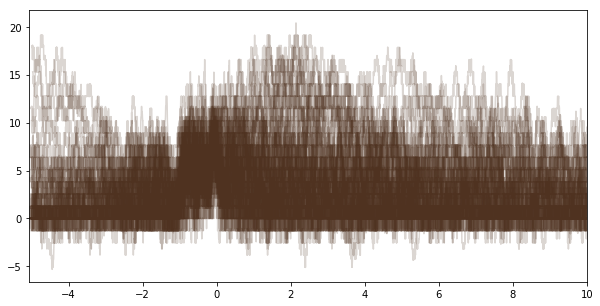

In [337]:
# Plot estimated interpatch velocity traces
fig, ax = plt.subplots(figsize=(10, 5))
t_min = math.inf
for i in range(-100, 0):
    ax.plot(t_ip[i], v_ip[i], color=cmap(0.25), alpha=0.2)
    if np.min(t_ip[i]) < t_min:
        t_min = np.min(t_ip[i])

ax.set_xlim([t_min, 10.0]);

#### Compare empirical interpatch distances with all walk-bout distances

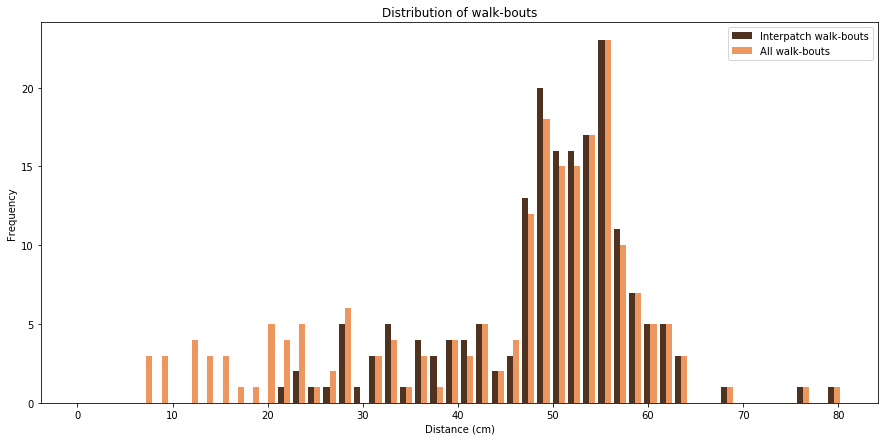

In [338]:
# Plot distribution
fig, ax = plt.subplots(figsize=(15, 7))
bins = np.linspace(0, np.max(remove_outliers(dx_run_all)), 51)
dx = [remove_outliers(dx_ip_all, thresh=5),
      #remove_outliers(dx_ip_2_all, thresh=5),
      remove_outliers(dx_run_all, thresh=5)]
labels = ['Interpatch walk-bouts',
          #'Interpatch walk-bouts (2)',
          'All walk-bouts']
ax.hist(dx, bins=bins, density=False, label=labels, color=[cmap(0.25), cmap(0.75)])
ax.set_title('Distribution of walk-bouts')
ax.set_xlabel('Distance (cm)')
ax.set_ylabel('Frequency')
ax.legend()

# Save figure
plt.savefig(results_dir + 'walkbout_distribution.png')

#### Empirical distibution simulation

##### Create function to sample from empirical distribution

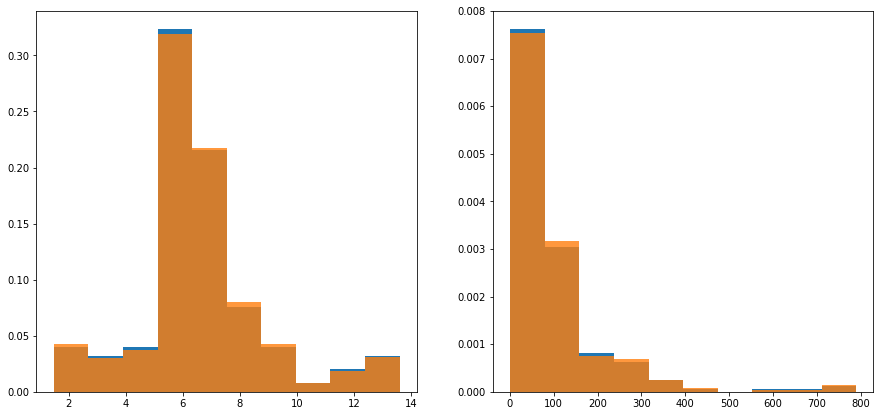

In [339]:
# Create distributions for walk- and still-bouts
d_run_all = EmpiricalDistribution(dt_run_all, outlier_thresh=thresh)
d_still_all = EmpiricalDistribution(dt_still_all, outlier_thresh=thresh)

# Compare sample and actual empirical distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].hist(remove_outliers(dt_run_all, thresh=thresh), density=True, bins=bins_run)
ax[0].hist(d_run_all.get_sample(size=10000), density=True, bins=bins_run, alpha=0.8)
ax[1].hist(remove_outliers(dt_still_all, thresh=thresh), density=True, bins=bins_still)
ax[1].hist(d_still_all.get_sample(size=10000), density=True, bins=bins_still, alpha=0.8);

##### Simulate sessions with empirical decision model
That is, run the session assuming the leaving decision is purely based on an movement signal unrelated to the patch-based forgaging task.

In [340]:
# Simulation parameters
num_steps_per_sim= 1000
num_sims_per_value = 20

# Animal parameters
velocity = None # take median running velocity of each session
decision_type = 'time'
decision_val = None
sdt_metrics = 'session'
sdt_bins = np.arange(21)/20
walk_metrics = 'global'
walk_bout_dist = dt_run_all
still_bout_dist = dt_still_all
still_bout_as_dv = True # overrides decision_val above

# Run simulations
data = simulate_sessions(filelist_sig,
                         num_steps_per_sim,
                         num_sims_per_value,
                         velocity=velocity,
                         decision_type=decision_type,
                         decision_val=decision_val,
                         sdt_metrics=sdt_metrics,
                         sdt_bins=sdt_bins,
                         hit_rate_dist=hit_rate_sig,
                         fa_rate_dist=fa_rate_sig,
                         walk_metrics=walk_metrics,
                         walk_bout_dist=walk_bout_dist,
                         still_bout_dist=still_bout_dist,
                         still_bout_as_dv=still_bout_as_dv,
                         session_names=training_days_sig,
                         verbose=True)
sim_data = data['sim_data']
env_data = data['env_data']

Simulating rodent session 21...
Simulating rodent session 22...
Simulating rodent session 24...
Simulating rodent session 25...
Simulating rodent session 30...
Simulating rodent session 32...
Simulating rodent session 35...
Simulating rodent session 41...
Simulating rodent session 42...
Simulating rodent session 43...
Done.


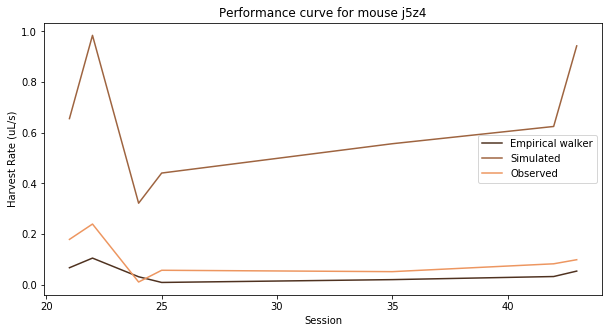

In [341]:
plot_idx = np.invert(np.isnan(harvest_rate_sig))
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(training_days_sig[plot_idx],
        np.mean(sim_data['r_total'][plot_idx], axis=2)/np.mean(sim_data['t_total'][plot_idx], axis=2),
        color=cmap(0.25),
        label='Empirical walker')
ax.plot(training_days_sig[plot_idx],
        harvest_rate_sim[plot_idx],
        color=cmap(0.50),
        label='Simulated')
ax.plot(training_days_sig[plot_idx],
        harvest_rate_sig[plot_idx],
        color=cmap(0.75),
        label='Observed')
ax.set_xlabel('Session')
ax.set_ylabel('Harvest Rate (uL/s)')
ax.set_title('Performance curve for mouse %s' % mouse_id)
ax.legend()
plt.savefig(results_dir + 'sim_vs_obs_performance_walkbout')

##### Simulate sessions with session-specific empirical distribution

In [342]:
# Simulation parameters
num_steps_per_sim= 1000
num_sims_per_value = 20

# Animal parameters
velocity = None # take median running velocity of each session
decision_type = 'time'
decision_val = None
sdt_metrics = 'session'
sdt_bins = np.arange(21)/20
walk_metrics = 'session'
walk_bout_dist = dt_run
still_bout_dist = dt_still
still_bout_as_dv = True # overrides decision_val above

# Run simulations
data = simulate_sessions(filelist_sig,
                         num_steps_per_sim,
                         num_sims_per_value,
                         velocity=velocity,
                         decision_type=decision_type,
                         decision_val=decision_val,
                         sdt_metrics=sdt_metrics,
                         sdt_bins=sdt_bins,
                         hit_rate_dist=hit_rate_sig,
                         fa_rate_dist=fa_rate_sig,
                         walk_metrics=walk_metrics,
                         walk_bout_dist=walk_bout_dist,
                         still_bout_dist=still_bout_dist,
                         still_bout_as_dv=still_bout_as_dv,
                         session_names=training_days_sig,
                         verbose=True)
sim_data = data['sim_data']
env_data = data['env_data']

Simulating rodent session 21...
Simulating rodent session 22...
Simulating rodent session 24...
Simulating rodent session 25...
Simulating rodent session 30...
Simulating rodent session 32...
Simulating rodent session 35...
Simulating rodent session 41...
Simulating rodent session 42...
Simulating rodent session 43...
Done.


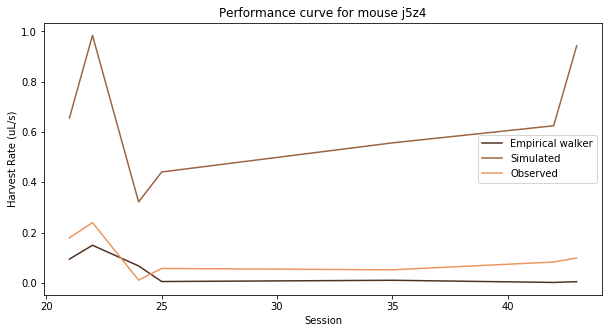

In [343]:
# Calculate harvest rate
harvest_rate_walk = np.squeeze(np.mean(sim_data['r_total'], axis=2) 
                               / np.mean(sim_data['t_total'], axis=2))

# Plot results
plot_idx = np.invert(np.isnan(harvest_rate_sig))
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(training_days_sig[plot_idx],
        harvest_rate_walk[plot_idx],
        color=cmap(0.25),
        label='Empirical walker')
ax.plot(training_days_sig[plot_idx],
        harvest_rate_sim[plot_idx],
        color=cmap(0.50),
        label='Simulated')
ax.plot(training_days_sig[plot_idx],
        harvest_rate_sig[plot_idx],
        color=cmap(0.75),
        label='Observed')
ax.set_xlabel('Session')
ax.set_ylabel('Harvest Rate (uL/s)')
ax.set_title('Performance curve for mouse %s' % mouse_id)
ax.legend()
plt.savefig(results_dir + 'sim_vs_obs_performance_walkbout')

#### Save analysis of walking statistics

In [344]:
# Create subfolder
d = results_dir + 'empirical_walker\\'
if not os.path.isdir(d):
    os.mkdir(d)

# Save sessions
filelist_sig = [filelist[i] for i in idx]
training_days_sig = training_days[idx]
f = open(d + 'filelist.txt', 'w')
for filename in filelist_sig:
    f.write(filename + '\n')
f.close()
np.save(d + 'training_days', training_days_sig)
    
# Save simulation data
np.save(d + 'sim_data', sim_data)
np.save(d + 'env_data', env_data)
np.save(d + 'harvest_rate', harvest_rate_walk)

# Write settings file
f = open(d + 'settings.txt', 'w')
f.write('Experiment params:\n')
f.write('Description: ' + exp_desc + '\n')
f.write('Steps per simulation = %d\n' % num_steps_per_sim)
f.write('Simulations per decision value = %d\n' % num_sims_per_value)
f.write('\nAnimal params:\n')
f.write('velocity = %s' % velocity)
f.write('decision_type = %s\n' % decision_type)
if isinstance(decision_val, np.ndarray):
    f.write('decision_val = %s\n' % 
            ('[' + ', '.join([str(dv) for dv in decision_val]) + ']'))
else:
    try:
        f.write('decision_val = %.2f\n' % decision_val)
    except TypeError:
        f.write('decision_val = %s\n' % str(decision_val))
f.write('sdt_metrics = %s' % sdt_metrics)
f.close()

# Save behavioral data
movement_data = {'walk_bout_time': dt_run,
                 'walk_bout_distance': dx_run,
                 'interpatch_distance': dx_ip,
                 'still_bout_time': dt_still}
np.save(d + 'movement_data', movement_data)

#### Poisson distribution

In [59]:
# Same as above, except with poisson distribution of walk and still bout patterns

### Batch analysis

#### List data locations

In [346]:
base_dir = 'G:\\My Drive\\Projects\\foraging\\data\\simulation_data\\'
mouse_ids = ['j4z2', 'j4z3', 'j4z4', 'j5z1', 'j5z2', 'j5z3', 'j5z4']
exp_names = ['%s_11-05-18' % name for name in mouse_ids]
results_dir = base_dir + 'batch_11-05-18\\'
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

#### SDT statistics
Plot hit rate, false alarm rate, d prime, and bias over all animals across sessions.

In [397]:
hit_rate = []
fa_rate = []
d_prime = []
c = []
training_days = []
for exp_name in exp_names:
    data = np.load(base_dir + exp_name + '\\observed\\behavior_data.npy')[()]
    hit_rate.append(data['hit_rate'])
    fa_rate.append(data['fa_rate'])
    d_prime.append(data['d_prime'])
    c.append(data['c'])
    
    training_days.append(np.load(base_dir + exp_name + '\\observed\\training_days.npy'))

C:\Users\Mcginley_Lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in subtract


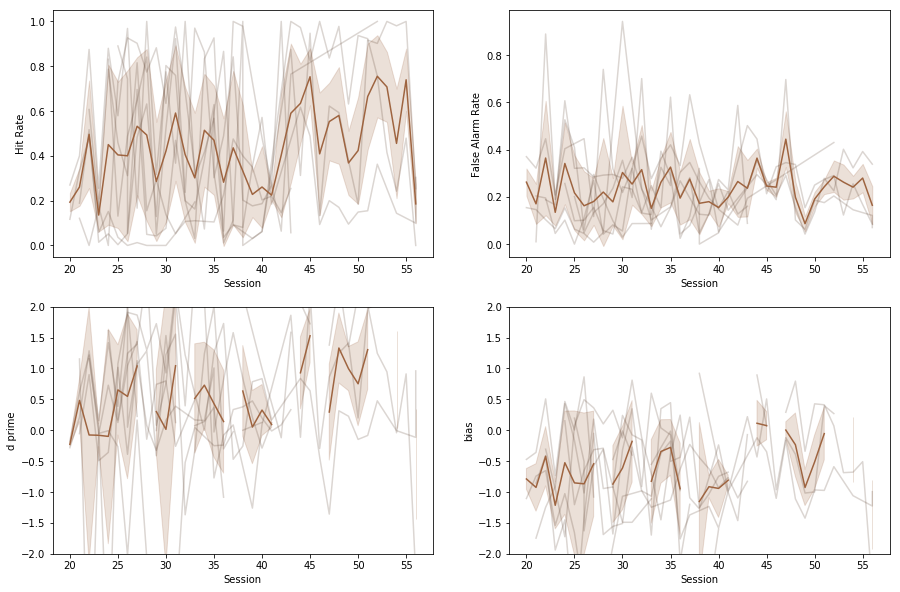

In [399]:
max_day = 0
for i in range(len(training_days)):
    if np.max(training_days[i]) > max_day:
        max_day = np.max(training_days[i])

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for i, m in enumerate([hit_rate, fa_rate, d_prime, c]):
    for j in range(len(exp_names)):
        ax[i//2, i%2].plot(training_days[j], m[j], color=cmap(0.25), alpha=0.2)

    mean = np.zeros(max_day)
    counts = np.zeros(max_day)
    for j in range(len(exp_names)):
        mean[training_days[j]-1] += m[j]
        counts[training_days[j]-1] += 1
    mean[counts > 0] = mean[counts > 0] / counts[counts > 0]

    std = np.zeros(max_day)
    for j in range(len(exp_names)):
        std[training_days[j]-1] += (m[j] - mean[training_days[j]-1])**2
    std = (std / len(exp_names))**0.5

    ax[i//2, i%2].plot(np.argwhere(counts > 0).flatten()+1, mean[counts>0], color=cmap(0.50))
    ax[i//2, i%2].fill_between(np.argwhere(counts > 0).flatten()+1, 
                               y1=mean[counts>0]-std[counts>0],
                               y2=mean[counts>0]+std[counts>0],
                               color=cmap(0.50),
                               alpha=0.2)
    ax[i//2, i%2].set_xlabel('Session')

# Set y labels
ax[0, 0].set_ylabel('Hit Rate')
ax[0, 1].set_ylabel('False Alarm Rate')
ax[1, 0].set_ylabel('d prime')
ax[1, 0].set_ylim([-2, 2])
ax[1, 1].set_ylabel('bias')
ax[1, 1].set_ylim([-2, 2])

# Save figure
plt.savefig(results_dir + 'sdt_metrics.png')

#### Sliding window performance
- Sliding window over each session across animals
- Average performance over time within session across animals

In [400]:
window_size = []
tt = []
r_bins = []
hr_win = []
hr_mean = []
hr_std = []
training_days = []
for exp_name in exp_names:
    data = np.load(base_dir + exp_name + '\\sliding_window\\window_data.npy')[()]
    #window_size.append(data['window_size'])
    window_size.append(300)
    tt.append(data['tt'])
    r_bins.append(data['r_bins'])
    hr_win.append(data['harvest_rate_win'])
    hr_mean.append(data['harvest_rate_mean'])
    hr_std.append(data['harvest_rate_std'])
    
    training_days.append(np.load(base_dir + exp_name + '\\sliding_window\\training_days.npy'))

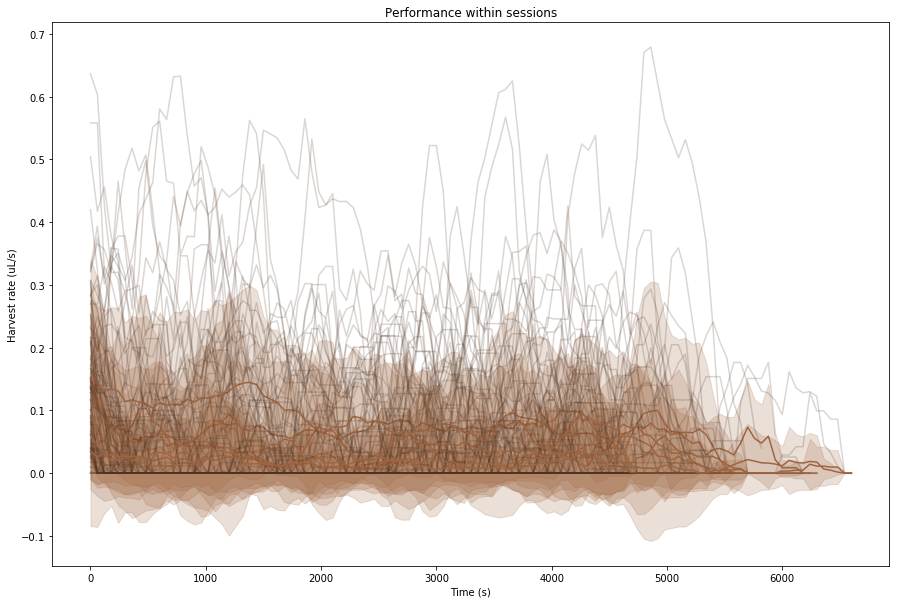

In [402]:
max_idx = np.zeros(len(exp_names), dtype=np.int32)
for i in range(len(exp_names)):
    for j in range(len(tt[i])):
        if len(tt[i][j]) > len(tt[i][max_idx[i]]):
            max_idx[i] = j
    
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(len(exp_names)):
    # Plot individual sessions
    for j in range(len(training_days[i])):
        if not np.isnan(r_bins[i][j]).all():
            ax.plot(tt[i][j], np.sum(r_bins[i][j], axis=1)/window_size[i], 
                    color=cmap(0.25), alpha=0.2)
    
    # Plot means for each animal
    ax.plot(tt[i][max_idx[i]], hr_mean[i], color=cmap(0.50))
    #ax.fill_between(tt[i][max_idx[i]], 
    #                y1=hr_mean[i]-hr_std[i],
    #                y2=hr_mean[i]+hr_std[i],
    #                color=cmap(0.50),
    #                alpha=0.2)

# Label figure
ax.set_title('Performance within sessions')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Harvest rate (uL/s)')

# Save figure
plt.savefig(results_dir + 'sliding_window.png')

#### Inclusion criteria
- Percent time active
- Decision criteria vs. simulation

In [579]:
f_active = []
hr_active = []
dt_leave = []
r_last = []
r_thresh_sim = []
training_days = []
n = 0
for exp_name in exp_names:
    data = np.load(base_dir + exp_name + '\\active_window\\active_data.npy')[()]
    f_active.append(data['f_active'])
    hr_active.append(data['harvest_rate'])
    dt_leave.append(data['dt_leave'])
    r_last.append(data['r_last'])
    n += len(data['f_active'])
    
    r_thresh_sim.append(np.load(base_dir + exp_name + '\\active_window\\r_thresh.npy'))
    
    training_days.append(np.load(base_dir + exp_name + '\\active_window\\training_days.npy'))

Percent active: 0.21


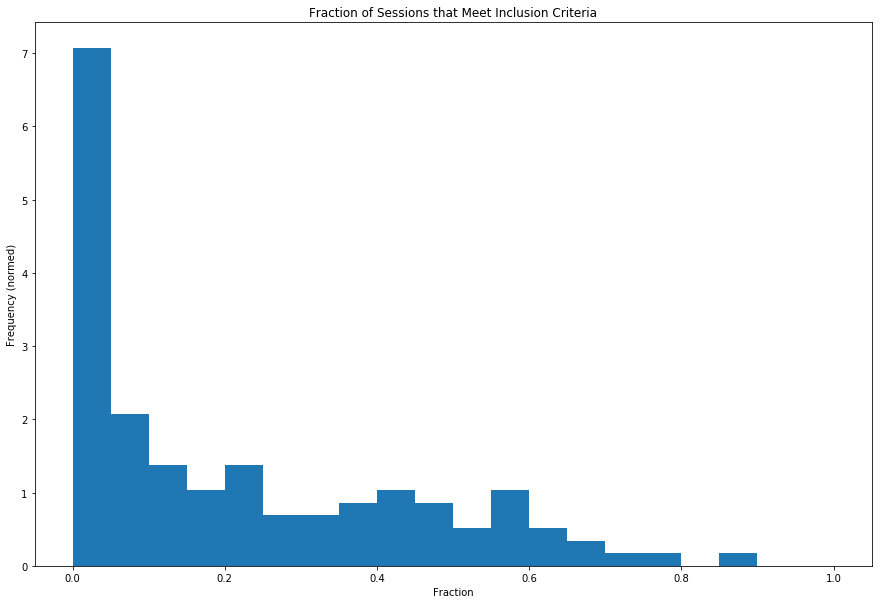

In [581]:
fig, ax = plt.subplots(figsize=(15, 10))
f_active_all = np.zeros(n)
j = 0
for i in range(len(exp_names)):
    f_active_all[j:j+len(f_active[i])] = f_active[i]
    j += len(f_active[i])

ax.hist(f_active_all, bins=np.arange(21)/20, density=True)
print('Percent active: %.2f' % (np.sum(f_active_all)/len(f_active_all)))

# Label figure
ax.set_title('Fraction of Sessions that Meet Inclusion Criteria')
ax.set_xlabel('Fraction')
ax.set_ylabel('Frequency (normed)')

# Save figure
plt.savefig(results_dir + 'f_active.png')

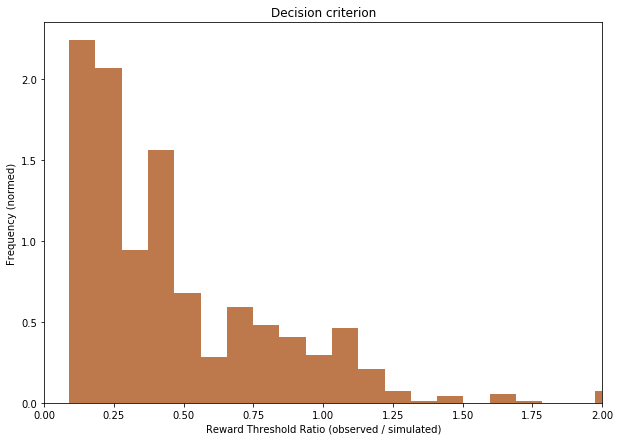

In [410]:
# Plot difference between observed and simulated reward threshold across active sessions
# during significant time windows
r_thresh_ratio_ = []
n = 0
for i in range(len(exp_names)):
    for j in range(len(training_days[i])):
        r_thresh_ratio_.append(r_last[i][j] / r_thresh_sim[i][j])
        n += len(r_last[i][j])

r_thresh_ratio = np.zeros(n)
k = 0
for i in range(len(r_thresh_ratio_)):
    r_thresh_ratio[k:k+len(r_thresh_ratio_[i])] = r_thresh_ratio_[i]
    k += len(r_thresh_ratio_[i])
r_thresh_ratio_ = None

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(r_thresh_ratio, bins=50, density=True, color=cmap(0.60))
ax.set_title('Decision criterion')
ax.set_xlabel('Reward Threshold Ratio (observed / simulated)')
ax.set_ylabel('Frequency (normed)')
#ax.set_xlim(ax.get_xlim()[0], -ax.get_xlim()[0])
ax.set_xlim(0.0, 2.0)

plt.savefig(results_dir + 'decision_criterion_diff.png')

#### Movement statistics
- Distribution of still- and walk-bouts
- Empirical vs. theoretical interpatch lengths

In [351]:
dt_still = []
dt_run = []
dx_run = []
dx_ip = []

for exp_name in exp_names:
    data = np.load(base_dir + exp_name + '\\empirical_walker\\movement_data.npy')[()]
    dt_still.append(data['still_bout_time'][0])
    dt_run.append(data['walk_bout_time'][0])
    dx_run.append(data['walk_bout_distance'][0])
    dx_ip.append(data['interpatch_distance'][0])

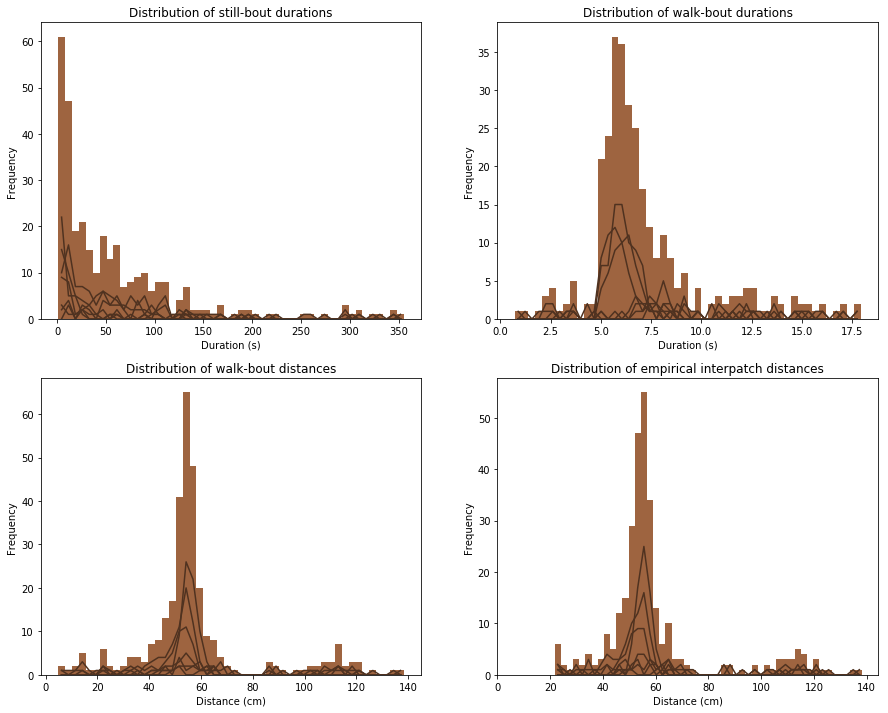

In [366]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
outlier_thresh = 2
plot_density = False

# Plot still-bout durations
dt_still_all = flatten_list(dt_still)
[n, bins, _] = ax[0, 0].hist(remove_outliers(dt_still_all, thresh=outlier_thresh),
                             bins=50, density=plot_density, color=cmap(0.5))
x = bins[:-1] + (bins[1] - bins[0]) / 2
for d in dt_still:
    [n, _] = np.histogram(d, bins=bins, density=plot_density)
    ax[0, 0].plot(x, n, color=cmap(0.25), alpha=1.0)
ax[0, 0].set_title('Distribution of still-bout durations')
ax[0, 0].set_xlabel('Duration (s)')
ax[0, 0].set_ylabel('Frequency')
    
# Plot walk-bout durations
dt_run_all = flatten_list(dt_run)
[n, bins, _] = ax[0, 1].hist(remove_outliers(dt_run_all, thresh=outlier_thresh), 
                             bins=50, density=plot_density, color=cmap(0.5))
x = bins[:-1] + (bins[1] - bins[0]) / 2
for d in dt_run:
    [n, _] = np.histogram(d, bins=bins, density=plot_density)
    ax[0, 1].plot(x, n, color=cmap(0.25), alpha=1.0)
ax[0, 1].set_title('Distribution of walk-bout durations')
ax[0, 1].set_xlabel('Duration (s)')
ax[0, 1].set_ylabel('Frequency')
    
# Plot walk-bout distances
dx_run_all = flatten_list(dx_run)
[n, bins, _] = ax[1, 0].hist(remove_outliers(dx_run_all, thresh=outlier_thresh), 
                             bins=50, density=plot_density, color=cmap(0.5))
x = bins[:-1] + (bins[1] - bins[0]) / 2
for d in dx_run:
    [n, _] = np.histogram(d, bins=bins, density=plot_density)
    ax[1, 0].plot(x, n, color=cmap(0.25), alpha=1.0)
ax[1, 0].set_title('Distribution of walk-bout distances')
ax[1, 0].set_xlabel('Distance (cm)')
ax[1, 0].set_ylabel('Frequency')
    
# Plot empirical interpatch distances
dx_ip_all = flatten_list(dx_ip)
[n, bins, _] = ax[1, 1].hist(remove_outliers(dx_ip_all, thresh=outlier_thresh), 
                             bins=50, density=plot_density, color=cmap(0.5))
x = bins[:-1] + (bins[1] - bins[0]) / 2
for d in dx_ip:
    [n, _] = np.histogram(d, bins=bins, density=plot_density)
    ax[1, 1].plot(x, n, color=cmap(0.25), alpha=1.0)
ax[1, 1].set_title('Distribution of empirical interpatch distances')
ax[1, 1].set_xlabel('Distance (cm)')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_xlim([0.0, ax[1, 1].get_xlim()[-1]])

# Save figure
plt.savefig(results_dir + 'walk_patterns.png')

#### Movement modeling
- Simulation vs. observed vs. empirical walking (ratio)

In [412]:
cmap = plt.get_cmap('terrain')

In [483]:
hr_active = []
hr_walk = []
hr_opt = []
training_days = []
n = 0
for exp_name in exp_names:
    # Extract harvest rates during active time windows
    data = np.load(base_dir + exp_name + '\\active_window\\active_data.npy')[()]
    hr_active.append(data['harvest_rate'])
    
    # Extract harvest rates for simulation of random walker
    data = np.load(base_dir + exp_name + '\\empirical_walker\\sim_data.npy')[()]
    hr_walk.append(np.squeeze(data['r_total'] / data['t_total']))
    
    # Extract harvest rates for simulation of optimal walker
    data = np.load(base_dir + exp_name + '\\active_window\\sim_data.npy')[()]
    hr_opt_ = data['r_total'] / data['t_total']
    
    # Save top harvest rate simulations per simulated session
    n_sess = hr_opt_.shape[0]
    n_sim = hr_opt_.shape[-1]
    #hr_opt_ = hr_opt_.reshape([n_sess, -1])
    #hr_opt_ = hr_opt_[np.repeat(np.arange(n_sess), n_sim),
    #                  np.argsort(hr_opt_, axis=1)[:, -n_sim:].flatten()]
    #hr_opt_ = hr_opt_.reshape([n_sess, n_sim])  
    idx_opt = np.argmax(np.mean(hr_opt_, axis=2), axis=1) # best decision value per session
    hr_opt.append(hr_opt_[np.arange(n_sess), idx_opt, :])
    
    # Extract training day for each session
    training_days.append(np.load(base_dir + exp_name + '\\active_window\\training_days.npy'))

##### Plot ratios

(0.0, 2.0)

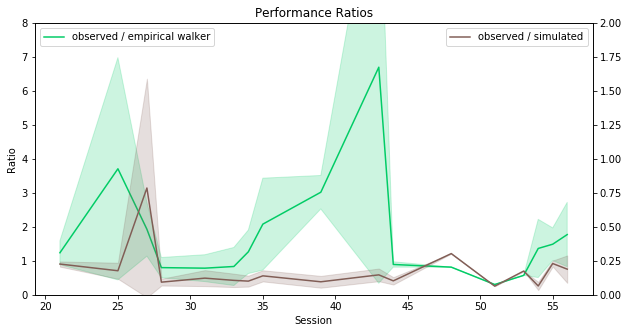

In [484]:
max_day = 0
for i in range(len(training_days)):
    if np.max(training_days[i]) > max_day:
        max_day = np.max(training_days[i])

mean = np.zeros([max_day, 3])
counts = np.zeros(max_day)
for i in range(len(exp_names)):
    #plot_idx = np.invert(np.isnan(hr_active[i]))
    mean[training_days[i]-1, 0] += hr_active[i] / np.mean(hr_walk[i], axis=1)
    mean[training_days[i]-1, 1] += hr_active[i] / np.mean(hr_opt[i], axis=1)
    counts[training_days[i]-1] += 1
mean[counts > 0] = mean[counts > 0] / counts[counts > 0, np.newaxis]

std = np.zeros([max_day, 2])
for i in range(len(exp_names)):
    plot_idx = np.invert(np.isnan(hr_active[i]))
    std[training_days[i]-1, 0] += (hr_active[i] / np.mean(hr_walk[i], axis=1)
                                   - mean[training_days[i]-1, 0])**2
    std[training_days[i]-1, 1] += (hr_active[i] / np.mean(hr_opt[i], axis=1)
                                   - mean[training_days[i]-1, 1])**2
std = (std / len(exp_names))**0.5

counts[np.isnan(mean)[:, 0]] = 0

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.argwhere(counts > 0).flatten()+1,
        mean[counts > 0, 0],
        color=cmap(0.25),
        label='observed / empirical walker')
ax.fill_between(np.argwhere(counts > 0).flatten()+1,
                y1=mean[counts > 0, 0]-std[counts > 0, 0],
                y2=mean[counts > 0, 0]+std[counts > 0, 0],
                color=cmap(0.25),
                alpha=0.2)
ax2 = ax.twinx()
ax2.plot(np.argwhere(counts > 0).flatten()+1,
        mean[counts > 0, 1],
        color=cmap(0.75),
        label='observed / simulated')
ax2.fill_between(np.argwhere(counts > 0).flatten()+1,
                 y1=mean[counts > 0, 1]-std[counts > 0, 1],
                 y2=mean[counts > 0, 1]+std[counts > 0, 1],
                 color=cmap(0.75),
                 alpha=0.2)
ax.set_xlabel('Session')
ax.set_ylabel('Ratio')
ax.set_ylim([0.0, 8])
ax.set_title('Performance Ratios')
ax.legend(loc=2)
ax2.legend(loc=1)
ax2.set_ylim([0.0, 2.0])

# Save figure
plt.savefig(results_dir + 'sim_vs_obs_performance_walkbout')

##### Plot all data points

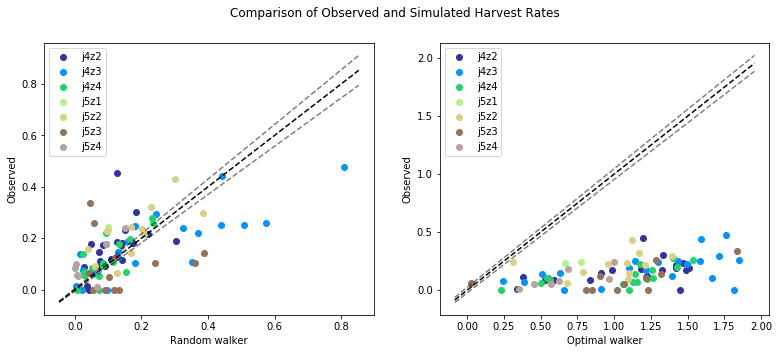

In [532]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Placeholders
mean_walk = []
std_walk  = []
mean_opt  = []
std_opt   = []

# Plot observed vs. mean simulated harvest rate
for i in range(len(exp_names)):
    mean_walk.append(np.mean(hr_walk[i], axis=1))
    std_walk.append(np.std(hr_walk[i], axis=1))
    mean_opt.append(np.mean(hr_opt[i], axis=1))
    std_opt.append(np.std(hr_opt[i],  axis=1))
    
    ax[0].scatter(np.mean(hr_walk[i], axis=1), 
                  hr_active[i], 
                  color=cmap(i/len(exp_names)), 
                  label=mouse_ids[i])
    ax[1].scatter(np.mean(hr_opt[i], axis=1), 
                  hr_active[i], 
                  color=cmap(i/len(exp_names)), 
                  label=mouse_ids[i])

# Plot line of equality +/- std
for ax_, [m, s] in zip(ax, [[mean_walk, std_walk], [mean_opt, std_opt]]):
    x_min, x_max = min(ax_.get_xlim()), max(ax_.get_xlim())
    y_min, y_max = min(ax_.get_ylim()), max(ax_.get_ylim())
    lim = [min(x_min, y_min), max(x_max, y_max)]
    #ax_.set_xlim(lim)
    #ax_.set_ylim(lim)
    ax_.plot(*[lim]*2, linestyle='--', color='black')
    x, idx_ = np.unique(flatten_list(m), return_index=True)
    y = flatten_list(s)[idx_]
    f = np.poly1d(np.polyfit(x, y, 1)) # best-fit line of std
    ax_.plot(lim, 
             np.asarray(lim) + f(lim),
             linestyle='--',
             color='black',
             alpha=0.5)
    ax_.plot(lim, 
             np.asarray(lim) - f(lim),
             linestyle='--',
             color='black',
             alpha=0.5)

# Set labels
fig.suptitle('Comparison of Observed and Simulated Harvest Rates')
ax[0].set_xlabel('Random walker')
ax[0].set_ylabel('Observed')
ax[0].legend()
ax[1].set_xlabel('Optimal walker')
ax[1].set_ylabel('Observed')
ax[1].legend()

# Save figure
plt.savefig(results_dir + 'sims_vs_obs_scatter.png')

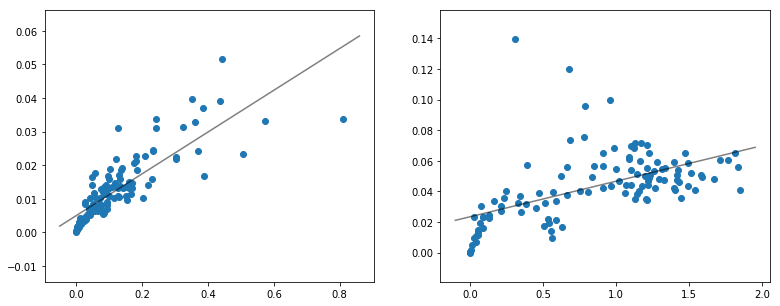

In [531]:
# Show best fit lines of std
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

for ax_, [m, s] in zip(ax, [[mean_walk, std_walk], [mean_opt, std_opt]]):
    ax_.scatter(flatten_list(m), flatten_list(s))
    x_min, x_max = min(ax_.get_xlim()), max(ax_.get_xlim())
    y_min, y_max = min(ax_.get_ylim()), max(ax_.get_ylim())
    lim = [min(x_min, y_min), max(x_max, y_max)]
    x, idx_ = np.unique(flatten_list(m), return_index=True)
    y = flatten_list(s)[idx_]
    f = np.poly1d(np.polyfit(x, y, 1)) # best-fit line of std
    ax_.plot(lim, 
             f(lim),
             linestyle='-',
             color='black',
             alpha=0.5)

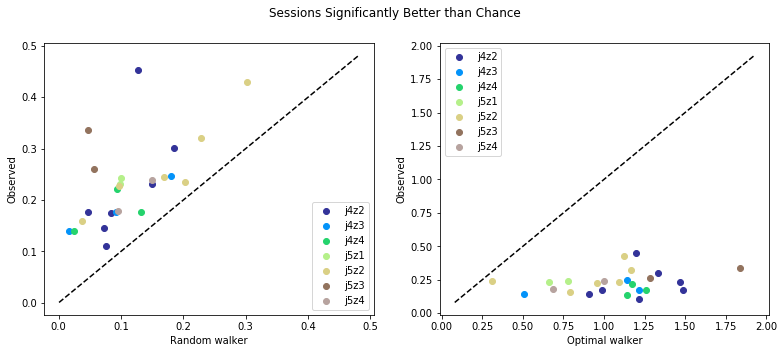

In [578]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Plot sessions significantly better than chance
hr_min = 0.10 # minimum observed harvest rate
num_sig = np.zeros(len(exp_names))
f_sig = np.zeros(len(exp_names))
for i in range(len(exp_names)):
    plot_idx = np.zeros(len(hr_active[i]), dtype=np.bool)
    hr_thresh = np.mean(hr_walk[i], axis=1) + 3*np.std(hr_walk[i], axis=1)
    plot_idx = np.logical_and(hr_active[i] > hr_thresh, hr_active[i] > hr_min)
    num_sig[i] = np.sum(plot_idx)
    f_sig[i] = np.sum(plot_idx) / len(plot_idx)
    
    ax[0].scatter(np.mean(hr_walk[i], axis=1)[plot_idx], 
                  hr_active[i][plot_idx], 
                  color=cmap(i/len(exp_names)), 
                  label=mouse_ids[i])
    ax[1].scatter(np.mean(hr_opt[i], axis=1)[plot_idx], 
                  hr_active[i][plot_idx], 
                  color=cmap(i/len(exp_names)), 
                  label=mouse_ids[i])

for ax_ in ax:
    x_min, x_max = min(ax_.get_xlim()), max(ax_.get_xlim())
    y_min, y_max = min(ax_.get_ylim()), max(ax_.get_ylim())
    lim = [min(x_min, y_min), max(x_max, y_max)]
    #ax_.set_xlim(lim)
    #ax_.set_ylim(lim)
    ax_.plot(*[lim]*2, linestyle='--', color='black')

# Set labels
fig.suptitle('Sessions Significantly Better than Chance')
ax[0].set_xlabel('Random walker')
ax[0].set_ylabel('Observed')
ax[0].legend()
ax[1].set_xlabel('Optimal walker')
ax[1].set_ylabel('Observed')
ax[1].legend();

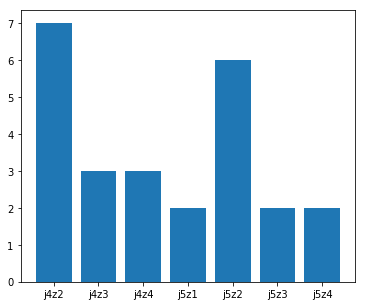

In [574]:
# Plot number and fraction of significant sessions for each mouse
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(np.arange(len(num_sig)), num_sig)
ax.set_xticklabels([''] + mouse_ids);

## Reinforcement Learning Model

In [ ]:
class PatchEnvironment:
    
    def __init__(self, 
                 d_patch, 
                 d_interpatch, 
                 r_init, 
                 r_decay, 
                 episode_timeout):
        
        self.d_patch = d_patch
        self.d_interpatch = d_interpatch
        self.r_init = r_init
        self.r_decay = r_decay
        self.trial = 0
        self.step = 0
        self.episode_timeout = episode_timeout
        
    
        
    def _harvest_reward(self):
        """
        Give reward according exponential decay function for trial number in patch.
        """
        
        
        

In [ ]:
class Mouse:
    
    def __init__(self, 
                 hit_rate, 
                 fa_rate, 
                 velocity, 
                 thresh_type='reward', 
                 thresh_val=2.0):
        
        
    
    def make_action(self, action):
        """
        Either choose to stay in patch (and harvest reward) or leave patch (and incur travel time delay).
        """
        if action == 0: # stay in patch
            r = self._harvest_reward()
        else:
            r = self._leave_patch()
        
        
        self.step += 1
        is_terminal = self.step > episode_timeout
        
        return r, is_terminal

## Archive

In [26]:
# Experiment parameters
num_steps_per_sim= 1000
num_sims_per_value = 20
sdt_bins = np.arange(21)/20
exp_name = 'j5z4_10-30-18'
exp_desc = 'data shape = [session, reward_thresh, num_sims]\n' \
           + 'excluded first 20 sessions due to different variable configs'
results_dir = 'G:\\My Drive\\Projects\\foraging\\data\\simulation_data\\%s\\' % exp_name
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

# Animal parameters (global)
#velocity = 5.0 # TODO: improve estimate
decision_type = 'reward'
decision_val = np.arange(2*5, 12*5+1) / 5

# Data placeholders
r_total = np.zeros([len(idx), decision_val.shape[0], num_sims_per_value])
t_total = np.zeros([len(idx), decision_val.shape[0], num_sims_per_value])
num_patches = np.zeros([len(idx), decision_val.shape[0], num_sims_per_value])
#hit_rate = np.zeros(len(filelist))
#fa_rate = np.zeros(len(filelist))

# Run over all sessions
for i, n in enumerate(idx):
    with h5py.File(filelist[n]) as f:
        # Environment parameters
        struct = f['Settings']['Property'] # matlab data structure
        d_interpatch = struct['SoundConfigurationRunConfigInterPatchDistcm'] # char array
        d_interpatch = float([u''.join(chr(c) for c in d_interpatch)][0]) # float
        r_init = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigRewarduL'])][0])
        decay = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigDecay'])][0]) / 100.0
        nc_avg = float([u''.join(chr(c) for c in struct['SoundConfigurationTargetSoundConfigAvgStartsec'])][0])
        target_duration = float([u''.join(chr(c) for c in struct['SoundConfigurationTargetSoundConfigTargetDurationsec'])][0])
        max_trial_duration = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTrialDurationMaxsec'])][0])
        iti = 1.5 # hard-coded
        fa_timeout = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigFalseAlarmTimeoutsec'])][0])
        try:
            end_patch_trial = \
                'true' == [u''.join(chr(c) for c in struct['SoundConfigurationRunConfigEndtargettrial'])][0].lower()
            end_patch_reward = \
                'true' == [u''.join(chr(c) for c in struct['SoundConfigurationRunConfigEndpatchreward'])][0].lower()
            if end_patch_trial:
                end_patch_type = 'trial'
                n_low = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTrialLow'])][0])
                n_high = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigTrialHigh'])][0])
                end_patch_val = [n_low, n_high]
            elif end_patch_reward:
                end_patch_type = 'reward'
                end_patch_val = float([u''.join(chr(c) for c in struct['SoundConfigurationRunConfigThresholduL'])][0])
            else:
                end_patch_type = None
                end_patch_val = None
        except KeyError as e:
            end_patch_type = None
            end_patch_val = None
        
        # Perceptual metrics
        if (hit_rate_sig[i].size > 0) and (fa_rate_sig[i].size > 0):
            [n_hit_rate, bins_hit_rate, _] = plt.hist(hit_rate_sig[i], bins=sdt_bins)
            [n_fa_rate, bins_fa_rate, _] = plt.hist(fa_rate_sig[i], bins=sdt_bins)
            plt.close()
            d_hit_rate = EmpiricalDistribution(n_hit_rate, bins_hit_rate)
            d_fa_rate = EmpiricalDistribution(n_fa_rate, bins_fa_rate)
            hit_rate = lambda: d_hit_rate.get_sample(size=1)[0]
            fa_rate = lambda: d_fa_rate.get_sample(size=1)[0]
        else:
            hit_rate = f['UntitledS_HitRate']['Data'][0, 0] / 100.0
            fa_rate = f['UntitledS_FARate']['Data'][0, 0] / 100.0
        
        # Animal parameters (session)
        #hit_rate[i] = f['UntitledS_HitRate']['Data'][0, 0] / 100.0
        #fa_rate[i] = f['UntitledS_FARate']['Data'][0, 0] / 100.0
        velocity = f['UntitledWheelSpeed']['Data'][0, :]
        velocity = np.median(velocity[velocity > 0.02])*100
            
    # Create environment
    patch = PatchEnvironment(d_interpatch,
                             r_init, 
                             decay,
                             nc_avg=nc_avg,
                             target_duration=target_duration,
                             max_trial_duration=max_trial_duration,
                             iti=iti,
                             fa_timeout=fa_timeout,
                             end_patch_type=end_patch_type,
                             end_patch_val=end_patch_val)
    
    print("Simulating rodent session %d of %d..." % (training_days[n], training_days[-1]))
    for j, dv in enumerate(decision_val):
        # Create animal object
        mouse = Rodent(hit_rate=hit_rate,
                       fa_rate=fa_rate,
                       velocity=velocity,
                       decision_type=decision_type,
                       decision_val=dv)

        for k in range(num_sims_per_value):
            r_total[i, j, k], t_total[i, j, k], num_patches[i, j, k] = \
                run_simulation(num_steps_per_sim, mouse, patch)

print('Done.')

Simulating rodent session 21 of 43...
Simulating rodent session 22 of 43...
Simulating rodent session 24 of 43...
Simulating rodent session 25 of 43...
Simulating rodent session 30 of 43...
Simulating rodent session 32 of 43...
Simulating rodent session 35 of 43...
Simulating rodent session 41 of 43...
Simulating rodent session 42 of 43...
Simulating rodent session 43 of 43...
Done.
